In [1]:
# 🖼️ Matplotlib settings

import warnings
import matplotlib.pyplot as plt
import shap
#sns.set_style("whitegrid")

plt.rcParams.update({
    'text.usetex': True,          # Enable LaTeX rendering
    'font.family': 'serif',       # Use serif fonts for a classic look
    'font.serif': ['Georgia'],    # Specify a serif font (e.g., Georgia)
    'font.weight': 'bold',      # Specify font weight                           ----------
    'figure.dpi': 200,            # Set the default DPI for clear visuals
    'figure.facecolor': 'white',  # Set the figure background color
    "axes.edgecolor": "grey",     # Border color for axes
    "axes.linewidth": 0.2,        # Border width for axes
    'axes.grid': True,            # Enable grid on axes
    'axes.labelweight': 'bold',       # Axis label bold                         ----------
    'axes.titleweight': 'bold',     # Axis title bold                           ----------
    'grid.color': 'grey',         # Grid color
    'grid.linestyle': '--',       # Dashed grid line style
    'grid.linewidth': 0.3,       # Grid line width
    'grid.alpha': 0.5,            # Grid transparency
    "axes.spines.top": False,     # Remove top spine
    "axes.spines.right": False,   # Remove right spine
    "legend.frameon": True,       # Enable frame around legends
    "legend.framealpha": 0.5      # Legend frame transparency
})

warnings.filterwarnings('ignore')

legend_box = dict(boxstyle="round,pad=0.3", fc="white", ec="0.8", alpha=0.9)

# 1. Stress & Redundancy Test - XGBoost

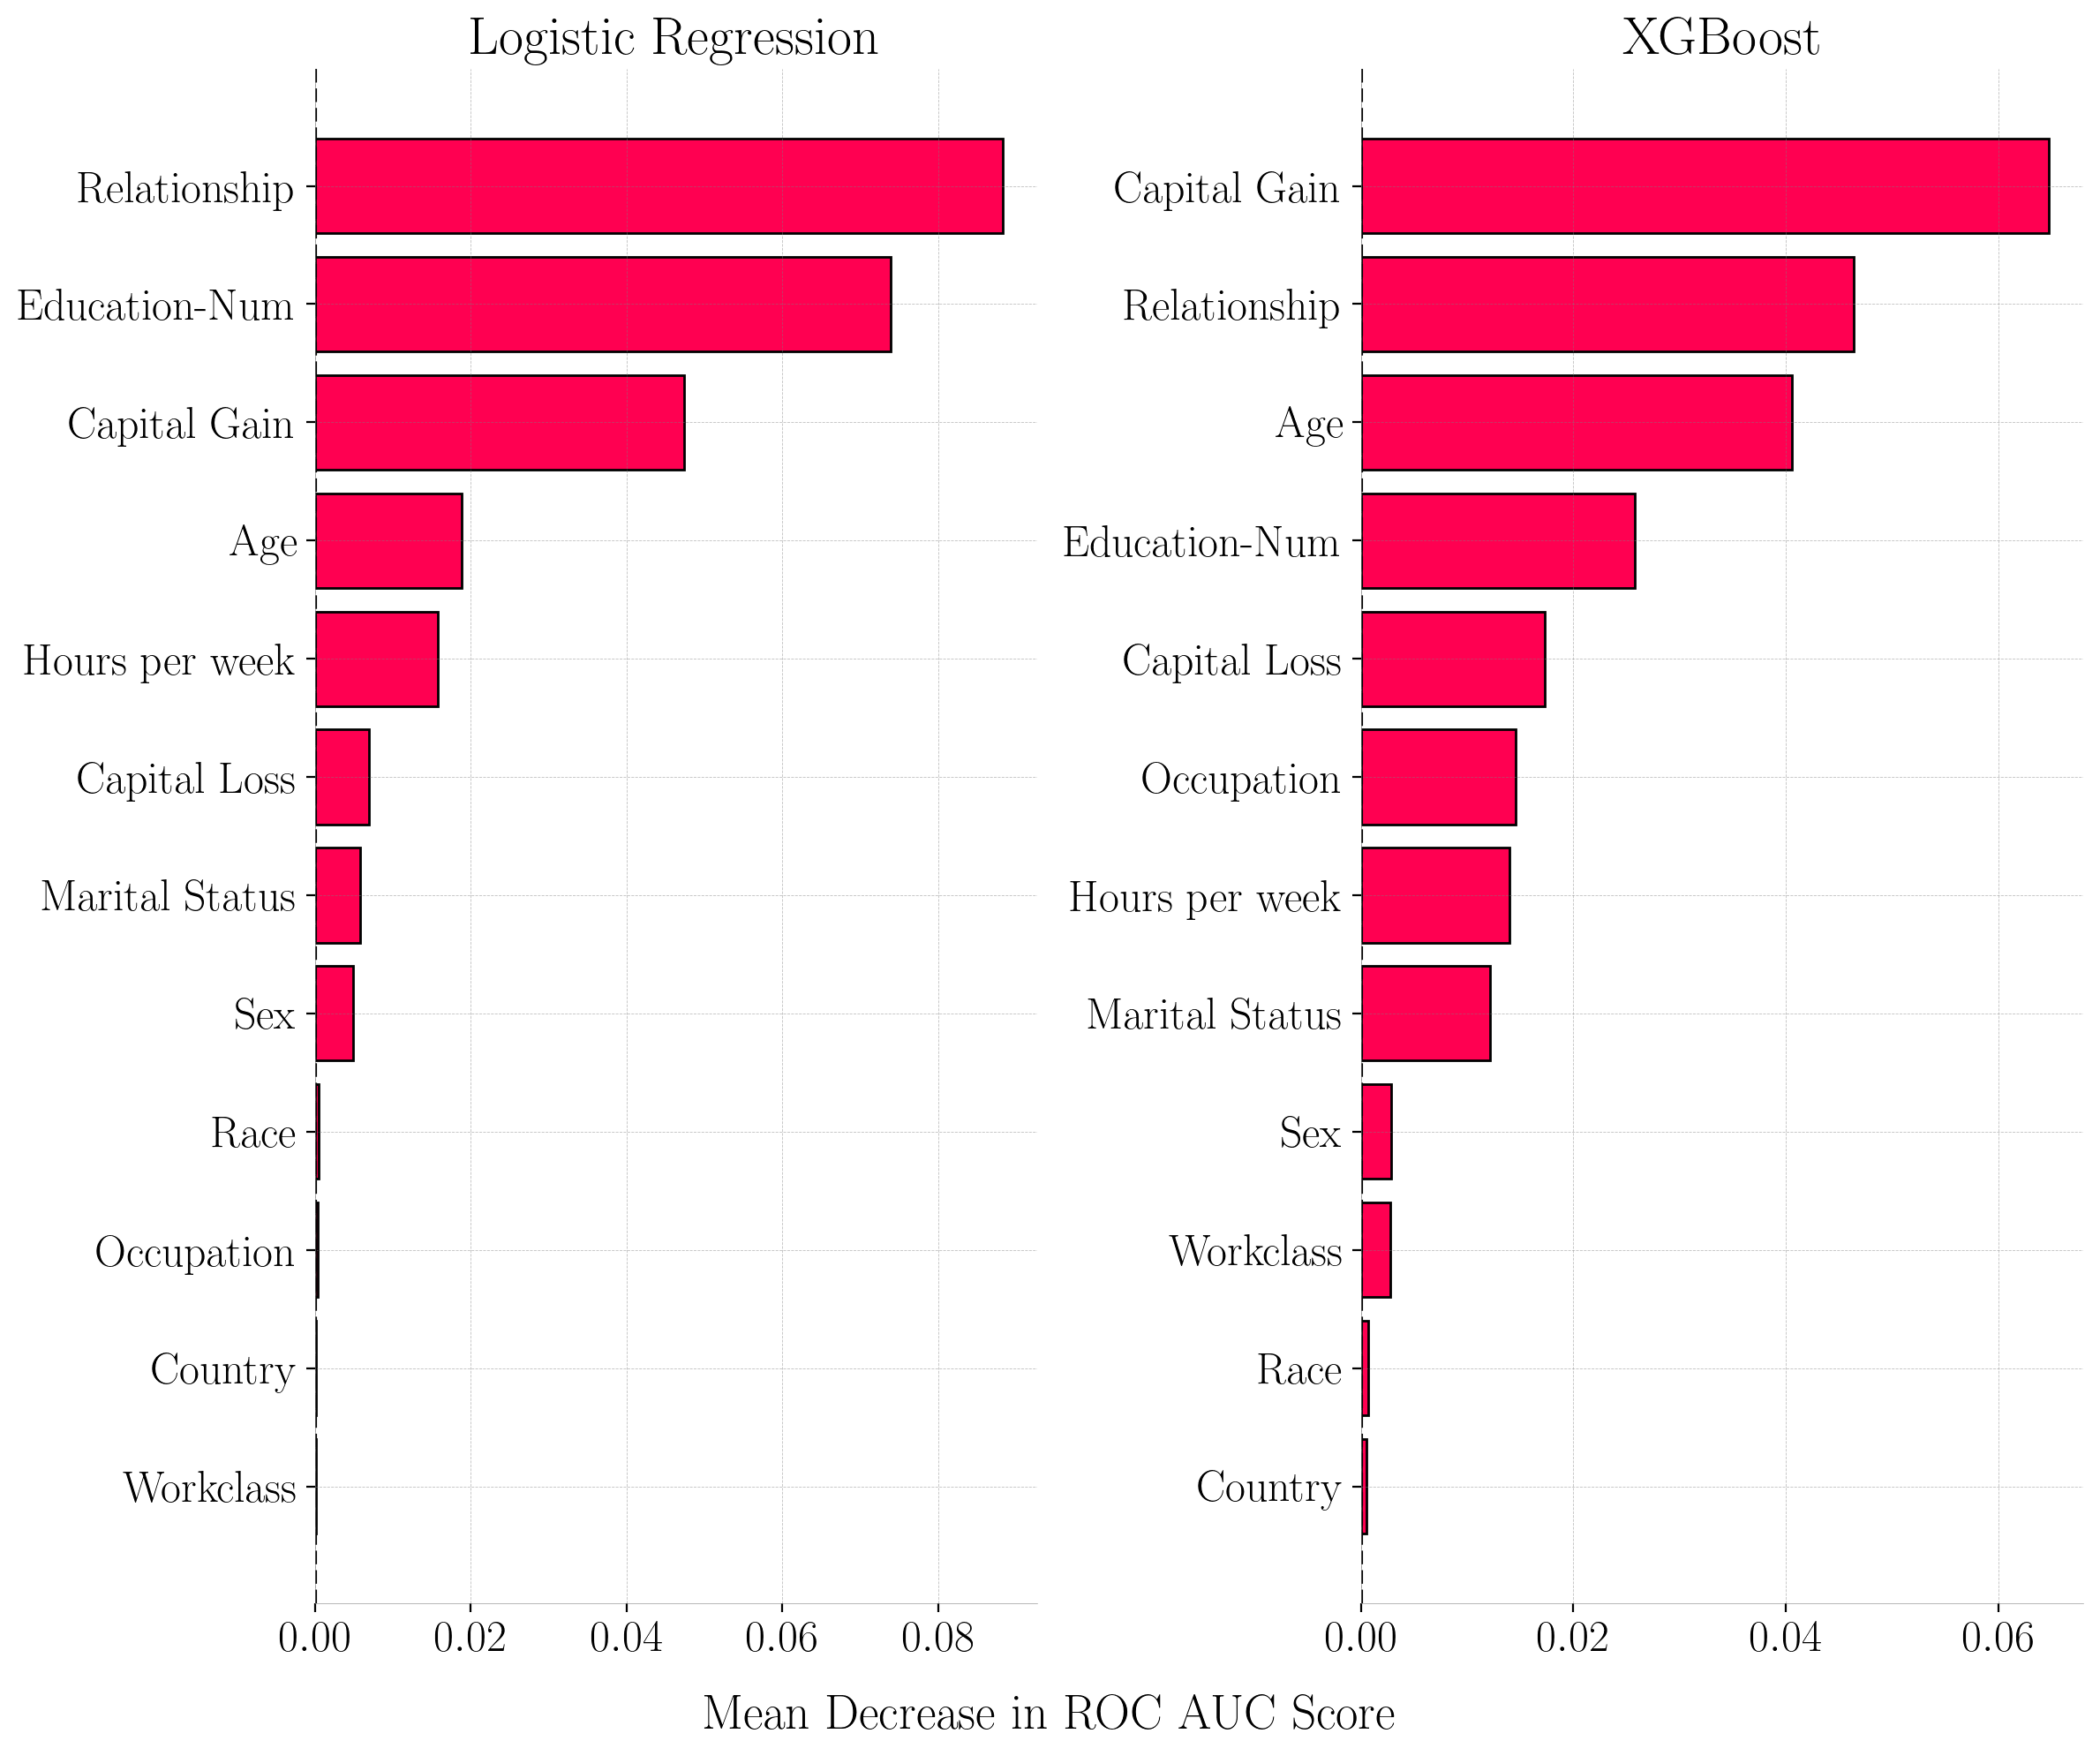

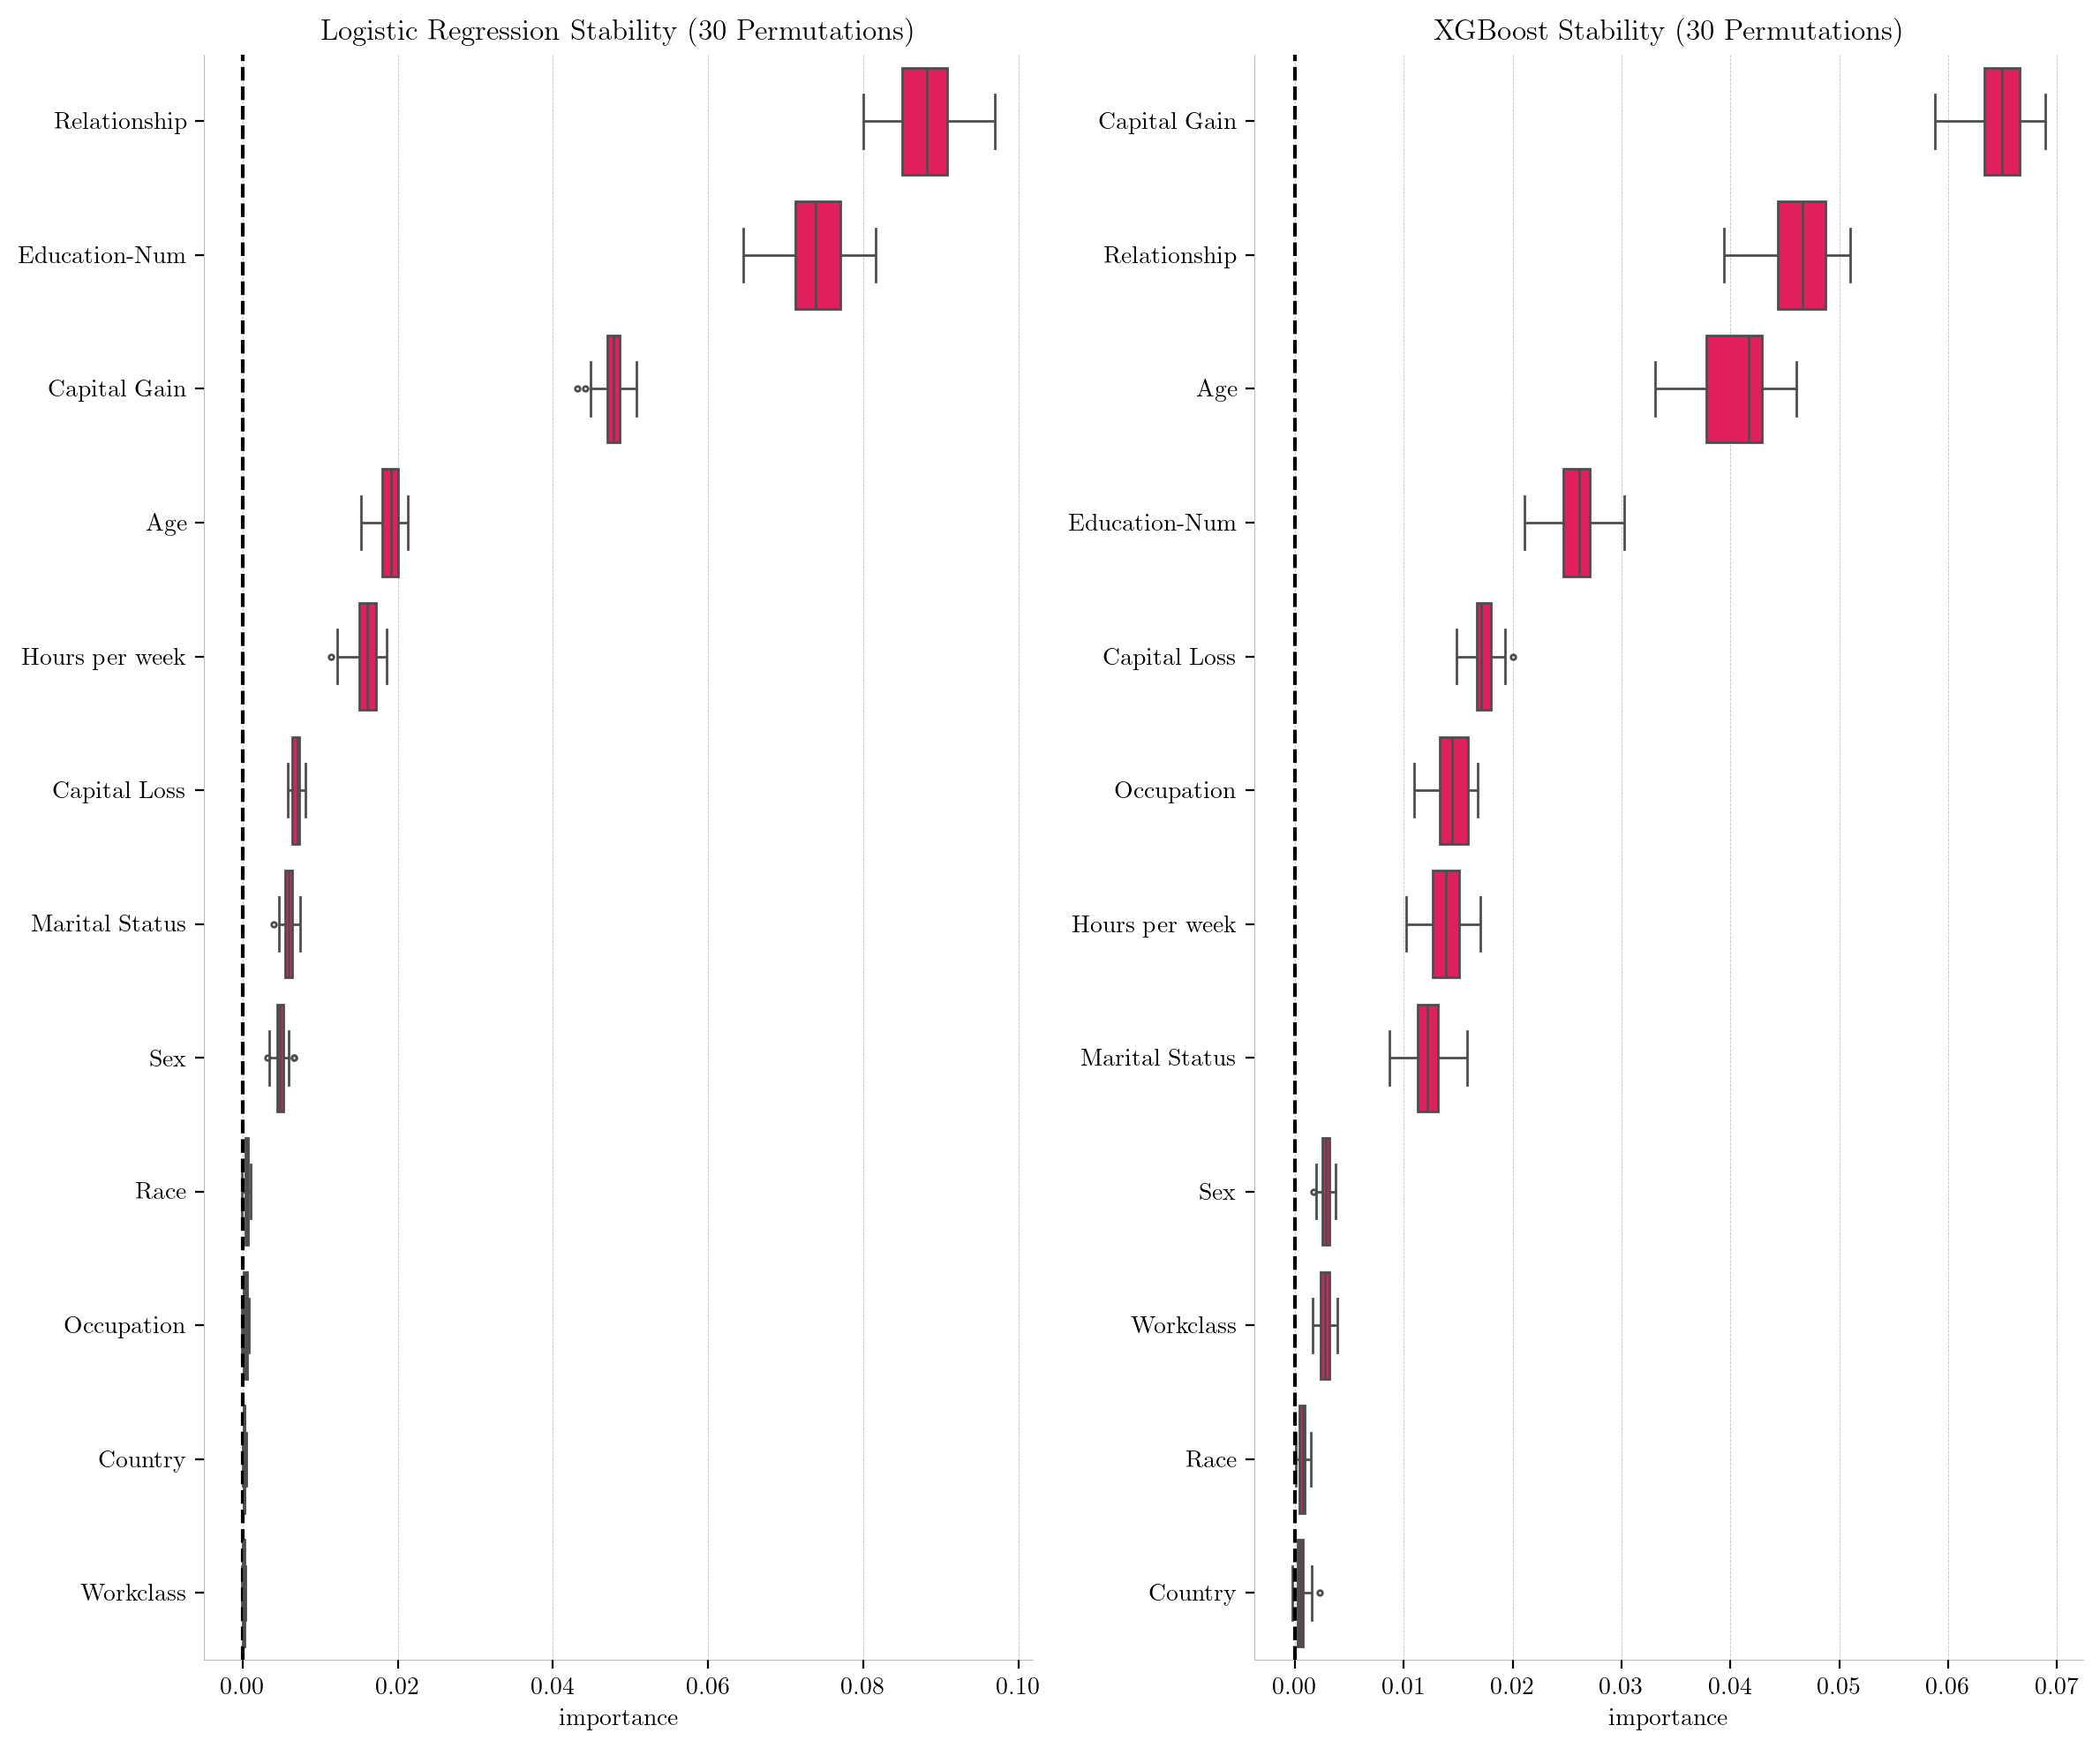

Logistic Regression Classification Report:
              precision    recall  f1-score   support

       False       0.87      0.94      0.90      4945
        True       0.74      0.56      0.64      1568

    accuracy                           0.85      6513
   macro avg       0.80      0.75      0.77      6513
weighted avg       0.84      0.85      0.84      6513

Logistic Regression ROC AUC Score:
0.8915903381069312
XGBoost Classification Report:
              precision    recall  f1-score   support

       False       0.90      0.94      0.92      4945
        True       0.77      0.69      0.73      1568

    accuracy                           0.88      6513
   macro avg       0.84      0.81      0.82      6513
weighted avg       0.87      0.88      0.87      6513

XGBoost ROC AUC Score:
0.9292712180928995

Logistic Regression — Permutation Feature Importance (ROC-AUC)
       feature  mean_roc_auc_decrease
  Relationship               0.088326
 Education-Num               0.07392

In [10]:
import pandas as pd
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import shap

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, roc_auc_score

# --- 1. Load & Prepare Adult Dataset ---
X, y = shap.datasets.adult()

# One-hot encode categorical variables
#X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale data for Logistic Regression
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X.columns,
    index=X_train.index
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns=X.columns,
    index=X_test.index
)

# --- 2. Train Models ---

# Model A: Logistic Regression
model_lr = LogisticRegression(
    max_iter=1000,
    #n_jobs=-1,
    #random_state=42
)
model_lr.fit(X_train_scaled, y_train)

# Model B: XGBoost
model_xgb = xgb.XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)
model_xgb.fit(X_train, y_train)

# --- 3. Compute Permutation Importance ---
r_lr = permutation_importance(
    model_lr,
    X_test_scaled,
    y_test,
    n_repeats=30,
    random_state=42,
    scoring='roc_auc'
)

r_xgb = permutation_importance(
    model_xgb,
    X_test,
    y_test,
    n_repeats=30,
    random_state=42,
    scoring='roc_auc'
)

# --- 4. Helper Function ---
def process_importance(importance_result, feature_names, top_n=20):
    df = pd.DataFrame({
        "feature": feature_names,
        "importance_mean": importance_result.importances_mean
    }).sort_values("importance_mean", ascending=False).head(top_n)

    sorted_feats = df["feature"].tolist()

    tidy_df = pd.DataFrame(
        importance_result.importances.T,
        columns=feature_names
    )[sorted_feats].melt(
        var_name="feature",
        value_name="importance"
    )

    return df, tidy_df, sorted_feats

df_lr, tidy_lr, feats_lr = process_importance(r_lr, X.columns)
df_xgb, tidy_xgb, feats_xgb = process_importance(r_xgb, X.columns)

# --- 5. Plotting Setup ---
shap_red = mcolors.to_hex(shap.plots.colors.red_blue(1.0))

# --- Part 1: Feature Importance Rankings ---
fig1, axes1 = plt.subplots(1, 2, figsize=(12, 10))

axes1[0].barh(
    df_lr["feature"],
    df_lr["importance_mean"],
    color=shap_red,
    edgecolor="black"
)
axes1[0].invert_yaxis()
axes1[0].set_title("Logistic Regression", fontsize=22)
#axes1[0].set_xlabel("Mean Decrease in ROC AUC Score")
axes1[0].axvline(0, color='k', linestyle='--')
axes1[0].tick_params(axis='y', labelsize=18)
axes1[0].tick_params(axis='x', labelsize=18)

axes1[1].barh(
    df_xgb["feature"],
    df_xgb["importance_mean"],
    color=shap_red,
    edgecolor="black"
)
axes1[1].invert_yaxis()
axes1[1].set_title("XGBoost", fontsize=22)
#axes1[1].set_xlabel("Mean Decrease in ROC AUC Score")
axes1[1].axvline(0, color='k', linestyle='--')
axes1[1].tick_params(axis='y', labelsize=18)
axes1[1].tick_params(axis='x', labelsize=18)

fig1.supxlabel("Mean Decrease in ROC AUC Score", fontsize=20)
plt.tight_layout()
plt.show()

# --- Part 2: Feature Stability ---
fig2, axes2 = plt.subplots(1, 2, figsize=(12, 10))

sns.boxplot(
    data=tidy_lr,
    x="importance",
    y="feature",
    order=feats_lr,
    orient="h",
    ax=axes2[0],
    color=shap_red,
    fliersize=2
)
axes2[0].set_title("Logistic Regression Stability (30 Permutations)")
axes2[0].axvline(0, color='k', linestyle='--')
axes2[0].set_ylabel("")

sns.boxplot(
    data=tidy_xgb,
    x="importance",
    y="feature",
    order=feats_xgb,
    orient="h",
    ax=axes2[1],
    color=shap_red,
    fliersize=2
)
axes2[1].set_title("XGBoost Stability (30 Permutations)")
axes2[1].axvline(0, color='k', linestyle='--')
axes2[1].set_ylabel("")

plt.tight_layout()
plt.show()

# --- 6. Classification Reports ---
print("Logistic Regression Classification Report:")
print(classification_report(y_test, model_lr.predict(X_test_scaled)))
print("Logistic Regression ROC AUC Score:")
print(roc_auc_score(y_test, model_lr.predict_proba(X_test_scaled)[:, 1]))

print("XGBoost Classification Report:")
print(classification_report(y_test, model_xgb.predict(X_test)))
print("XGBoost ROC AUC Score:")
print(roc_auc_score(y_test, model_xgb.predict_proba(X_test)[:, 1]))

# --- 7. Print Final PFI Tables (Mean ROC-AUC Decrease) ---

def print_pfi_table(importance_result, feature_names, model_name):
    df = pd.DataFrame({
        "feature": feature_names,
        "mean_roc_auc_decrease": importance_result.importances_mean
    }).sort_values("mean_roc_auc_decrease", ascending=False)
    
    print(f"\n{model_name} — Permutation Feature Importance (ROC-AUC)")
    print(df.to_string(index=False))

print_pfi_table(r_lr, X.columns, "Logistic Regression")
print_pfi_table(r_xgb, X.columns, "XGBoost")

In [1]:
import shap
import pandas as pd
from sklearn.model_selection import train_test_split

# 1. Load data
X, y = shap.datasets.adult()

# 2. Split (using same seed/stratify as your training code)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3. Calculate percentage of zeros in 'Capital Gain'
# We check where value is equal to 0
zero_mask_test = (X_test["Capital Gain"] == 0)
zero_count_test = zero_mask_test.sum()
total_count_test = len(X_test)

pct_zeros_test = (zero_count_test / total_count_test) * 100

print(f"--- Adult Dataset (Test Split) ---")
print(f"Total rows in X_test: {total_count_test}")
print(f"Rows with Capital Gain == 0: {zero_count_test}")
print(f"Percentage of zeros: {pct_zeros_test:.2f}%")

# Optional: Check 'Capital Loss' as well, as it is often similar
zero_mask_loss = (X_test["Capital Loss"] == 0)
pct_zeros_loss = (zero_mask_loss.sum() / total_count_test) * 100
print(f"Percentage of zeros in Capital Loss: {pct_zeros_loss:.2f}%")

--- Adult Dataset (Test Split) ---
Total rows in X_test: 6513
Rows with Capital Gain == 0: 5950
Percentage of zeros: 91.36%
Percentage of zeros in Capital Loss: 95.46%


In [ ]:
import pandas as pd

def load_adult_dataset(data_folder):
    # Define column names based on adult.names
    columns = [
        "age", "workclass", "fnlwgt", "education", "education-num",
        "marital-status", "occupation", "relationship", "race", "sex",
        "capital-gain", "capital-loss", "hours-per-week", "native-country", "income"
    ]
    
    # Load training data
    train_path = f"{data_folder}/adult.data"
    try:
        df_train = pd.read_csv(train_path, header=None, names=columns, na_values=" ?", skipinitialspace=True)
    except FileNotFoundError:
        # Some distributions use 'adult' instead of 'adult.data'
        train_path = f"{data_folder}/adult"
        df_train = pd.read_csv(train_path, header=None, names=columns, na_values=" ?", skipinitialspace=True)
    
    # Load test data
    test_path = f"{data_folder}/adult.test"
    df_test = pd.read_csv(test_path, header=0, names=columns, na_values=" ?", skipinitialspace=True, comment='|')
    # Remove the '.' at the end of income in test set
    df_test['income'] = df_test['income'].str.replace('.', '', regex=False)
    
    # Concatenate train and test
    df = pd.concat([df_train, df_test], ignore_index=True)
    return df

my_df = load_adult_dataset(r"C:\Users\jk200\Desktop\Ehhh\SHAP\data\adult")
my_df

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48836,39,Private,215419,Bachelors,13,Divorced,Prof-specialty,Not-in-family,White,Female,0,0,36,United-States,<=50K
48837,64,?,321403,HS-grad,9,Widowed,?,Other-relative,Black,Male,0,0,40,United-States,<=50K
48838,38,Private,374983,Bachelors,13,Married-civ-spouse,Prof-specialty,Husband,White,Male,0,0,50,United-States,<=50K
48839,44,Private,83891,Bachelors,13,Divorced,Adm-clerical,Own-child,Asian-Pac-Islander,Male,5455,0,40,United-States,<=50K


In [ ]:
import shap

X, y = shap.datasets.adult()

# for col in ["Workclass", "Marital Status", "Occupation", "Relationship", "Race", "Sex", "Country"]:
#     X[col] = pd.factorize(X[col])[0]
    
X

,Age,Workclass,Education-Num,Marital Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country
0,39.0,7,13.0,4,1,0,4,1,2174.0,0.0,40.0,39
1,50.0,6,13.0,2,4,4,4,1,0.0,0.0,13.0,39
2,38.0,4,9.0,0,6,0,4,1,0.0,0.0,40.0,39
3,53.0,4,7.0,2,6,4,2,1,0.0,0.0,40.0,39
4,28.0,4,13.0,2,10,5,2,0,0.0,0.0,40.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27.0,4,12.0,2,13,5,4,0,0.0,0.0,38.0,39
32557,40.0,4,9.0,2,7,4,4,1,0.0,0.0,40.0,39
32558,58.0,4,9.0,6,1,1,4,0,0.0,0.0,40.0,39
32559,22.0,4,9.0,4,1,3,4,1,0.0,0.0,20.0,39


In [ ]:
# count the number of outcomes in a traget variable
y #y is a np.array
import numpy as np
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

{False: 24720, True: 7841}

In [ ]:
24720 / (24720 + 7841)

0.7591904425539756

Loading and preprocessing Adult dataset...
Training baseline XGBoost model...

=== Baseline Model Classification Report ===
              precision    recall  f1-score   support

       False       0.90      0.94      0.92      4942
        True       0.77      0.68      0.73      1571

    accuracy                           0.88      6513
   macro avg       0.84      0.81      0.82      6513
weighted avg       0.87      0.88      0.87      6513

0.9279994853090245

Calculating feature rankings...

================ FEATURE RANKINGS WITH VALUES ================

>>> SHAP Ranking (mean |SHAP value|)
           Feature  SHAP_Importance
0     Relationship         1.098377
1              Age         0.817794
2     Capital Gain         0.590530
3    Education-Num         0.537272
4       Occupation         0.411532
5   Hours per week         0.397480
6   Marital Status         0.366382
7     Capital Loss         0.179189
8              Sex         0.156324
9        Workclass         0.119049

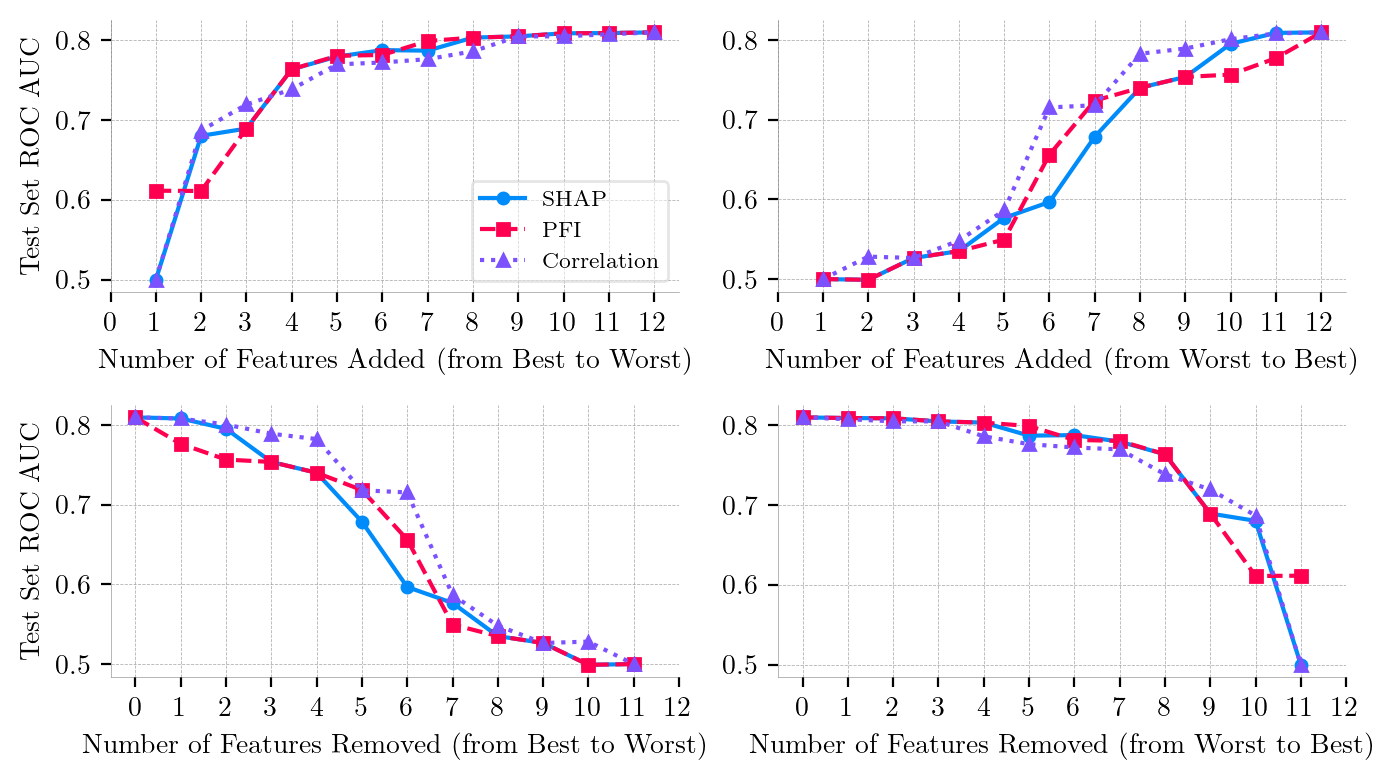

Done.


In [ ]:
import pandas as pd
import numpy as np
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score, roc_auc_score, classification_report

# ==========================================
# 1. LOAD & PREPROCESS DATA (Adult Dataset)
# ==========================================
print("Loading and preprocessing Adult dataset...")
X, y = shap.datasets.adult()
X = pd.DataFrame(X, columns=X.columns)

# Handle Missing Values & Encoding
for col in X.columns:
    if X[col].dtype == 'object' or X[col].dtype.name == 'category':
        X[col] = X[col].fillna(X[col].mode()[0])
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
    else:
        X[col] = X[col].fillna(X[col].mean())

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale Data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

# Train Baseline XGBoost Model
print("Training baseline XGBoost model...")
model = xgb.XGBClassifier(
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)
model.fit(X_train_scaled, y_train)

baseline_pred = model.predict(X_test_scaled)
print("\n=== Baseline Model Classification Report ===")
print(classification_report(y_test, baseline_pred))
print(roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1]))
print("============================================\n")

# ==========================================
# 2. CALCULATE IMPORTANCE RANKINGS
# ==========================================
print("Calculating feature rankings...")
feature_names = X.columns.tolist()

# A. SHAP Ranking
    explainer = shap.TreeExplainer(model)
    shap_values = explainer(X_test_scaled) 
shap_importance = np.abs(shap_values.values).mean(axis=0)
shap_ranking = [x for _, x in sorted(zip(shap_importance, feature_names), reverse=True)]

# B. PFI Ranking
pfi = permutation_importance(
    model, X_test_scaled, y_test, n_repeats=10, random_state=42, scoring='roc_auc', n_jobs=-1
)
pfi_ranking = [x for _, x in sorted(zip(pfi.importances_mean, feature_names), reverse=True)]

# C. Correlation Ranking (Pearson)
train_df = X_train_scaled.copy()
train_df['target'] = y_train
corr_values = train_df.corr(method='pearson')['target'].abs().drop('target')
corr_ranking = corr_values.sort_values(ascending=False).index.tolist()

rankings = {"SHAP": shap_ranking, "PFI": pfi_ranking, "Correlation": corr_ranking}

# ==========================================
# 2.1 PRINT FEATURE RANKINGS WITH VALUES
# ==========================================
print("\n================ FEATURE RANKINGS WITH VALUES ================\n")

# A. SHAP
shap_df = pd.DataFrame({
    "Feature": feature_names,
    "SHAP_Importance": shap_importance
}).sort_values("SHAP_Importance", ascending=False)

print(">>> SHAP Ranking (mean |SHAP value|)")
print(shap_df.reset_index(drop=True).to_string(index=True))
print("\n" + "-"*70 + "\n")

# B. Permutation Feature Importance (PFI)
pfi_df = pd.DataFrame({
    "Feature": feature_names,
    "PFI_Importance": pfi.importances_mean
}).sort_values("PFI_Importance", ascending=False)

print(">>> Permutation Feature Importance Ranking (ROC AUC score drop)")
print(pfi_df.reset_index(drop=True).to_string(index=True))
print("\n" + "-"*70 + "\n")

# C. Correlation
corr_df = corr_values.reset_index()
corr_df.columns = ["Feature", "Abs_Pearson_Correlation"]
corr_df = corr_df.sort_values("Abs_Pearson_Correlation", ascending=False)

print(">>> Correlation Ranking (|Pearson r| with target)")
print(corr_df.reset_index(drop=True).to_string(index=True))
print("\n===============================================================\n")


# ==========================================
# 3. EVALUATION LOGIC
# ==========================================
def get_scores(ranking, mode, X_tr, y_tr, X_te, y_te):
    scores = []
    x_axis = []
    n_features = len(ranking)
    
    if 'add' in mode: k_range = range(1, n_features + 1)
    else: k_range = range(0, n_features) 

    for k in k_range:
        if mode == 'add_best':
            selected = ranking[:k]
            x_val = k
        elif mode == 'add_worst':
            selected = ranking[::-1][:k]
            x_val = k
        elif mode == 'remove_best':
            selected = [f for f in ranking if f not in ranking[:k]]
            x_val = k
        elif mode == 'remove_worst':
            bottom_k = ranking[::-1][:k]
            selected = [f for f in ranking if f not in bottom_k]
            x_val = k
            
        if len(selected) == 0: scores.append(0)
        else:
            clf = xgb.XGBClassifier(
                eval_metric='logloss', use_label_encoder=False, random_state=42, n_jobs=-1, verbosity=0
            )
            clf.fit(X_tr[selected], y_tr)
            pred = clf.predict(X_te[selected])
            scores.append(roc_auc_score(y_te, pred))
        x_axis.append(x_val)
    return x_axis, scores

# ==========================================
# 4. PLOTTING THE MATRIX
# ==========================================
print("Generating plots...")

# Removed sharey=True to ensure y-ticks (numbers) appear on all plots
fig, axes = plt.subplots(2, 2, figsize=(7, 4)) 

scenarios = [
    ("add_best", axes[0, 0], "Number of Features Added (from Best to Worst)"),
    ("add_worst", axes[0, 1], "Number of Features Added (from Worst to Best)"),
    ("remove_best", axes[1, 0], "Number of Features Removed (from Best to Worst)"),
    ("remove_worst", axes[1, 1], "Number of Features Removed (from Worst to Best)")
]

colors = {"SHAP": "#008BFB", "PFI": "#FF0051", "Correlation": "#7C52FF"}
markers = {"SHAP": 'o', "PFI": 's', "Correlation": '^'}
styles = {"SHAP": '-', "PFI": '--', "Correlation": ':'}

for i, (mode, ax, xlabel_text) in enumerate(scenarios):
    print(f"Running scenario: {mode}...")
    
    for method_name, ranking_list in rankings.items():
        xs, ys = get_scores(ranking_list, mode, X_train_scaled, y_train, X_test_scaled, y_test)
        ax.plot(xs, ys, label=f'{method_name}', color=colors[method_name], 
                marker=markers[method_name], linestyle=styles[method_name], 
                markersize=4, linewidth=1.5)

    # Formatting
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.set_xlabel(xlabel_text, fontsize=10)
    
    # Show y-label TEXT only on left plots (index 0 and 2)
    # Since sharey=False, the tick numbers will appear on all plots automatically.
    if i % 2 == 0:
        ax.set_ylabel('Test Set ROC AUC', fontsize=10)
    
    # Set xticks 0 to 12 explicitly
    ax.set_xticks(range(0, 13, 1))
    
    # Add legend only to the first plot
    if i == 0:
        ax.legend(loc='lower right', fontsize=8)

plt.tight_layout()
plt.show()
print("Done.")

Loading and preprocessing Adult dataset...
Training baseline XGBoost model...
Baseline ROC AUC: 0.9293
Calculating feature rankings...

Generating Iterative Feature Selection Scores...

################################################################################
SCENARIO: ADD BEST
################################################################################

--- Method: SHAP ---
 Step  Feature_Added  ROC_AUC
    1            Age 0.708135
    2   Relationship 0.821435
    3 Marital Status 0.822753
    4   Capital Gain 0.872346
    5  Education-Num 0.906139
    6 Hours per week 0.910228
    7     Occupation 0.916486
    8            Sex 0.917458
    9   Capital Loss 0.927585
   10      Workclass 0.929237
   11           Race 0.929510
   12        Country 0.929213
------------------------------------------------------------

--- Method: PFI ---
 Step  Feature_Added  ROC_AUC
    1   Capital Gain 0.626112
    2   Relationship 0.843284
    3            Age 0.871529
    4  Education-Nu

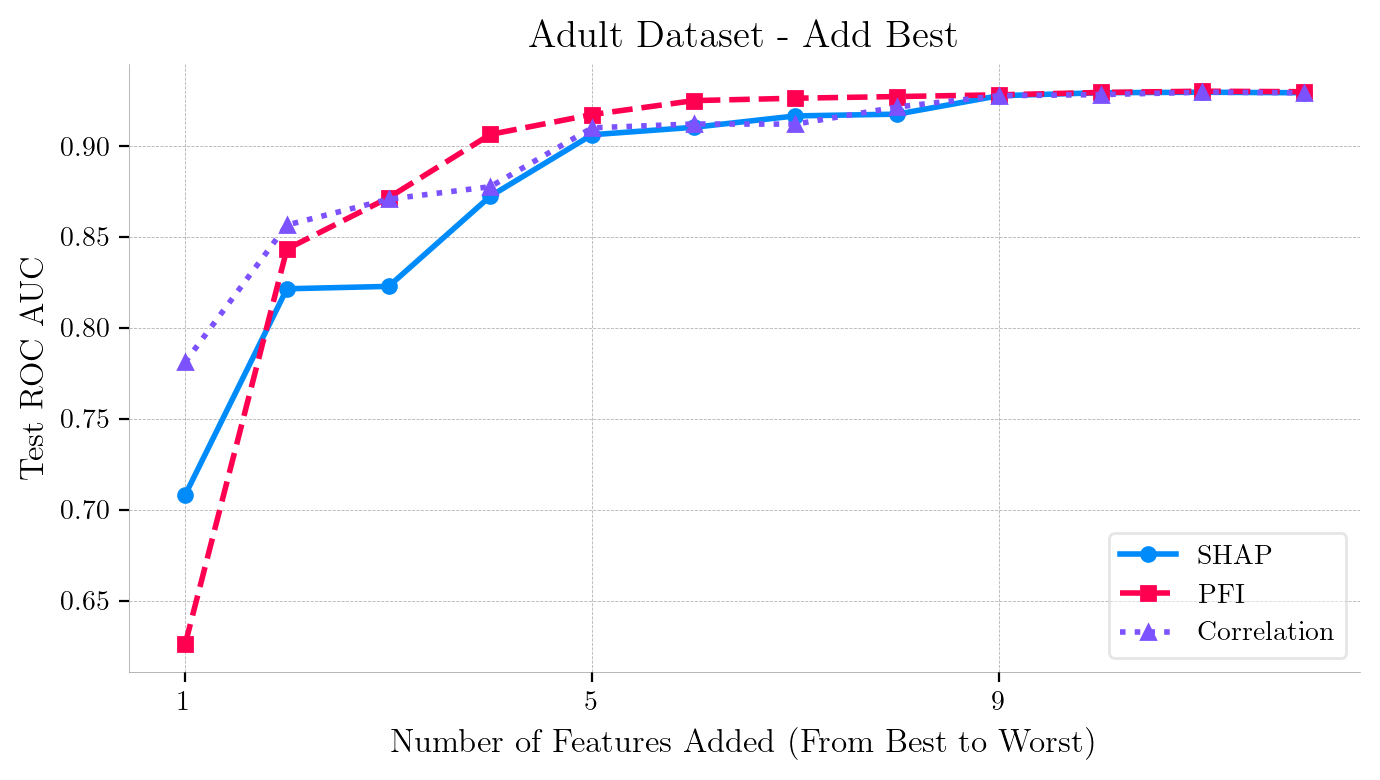

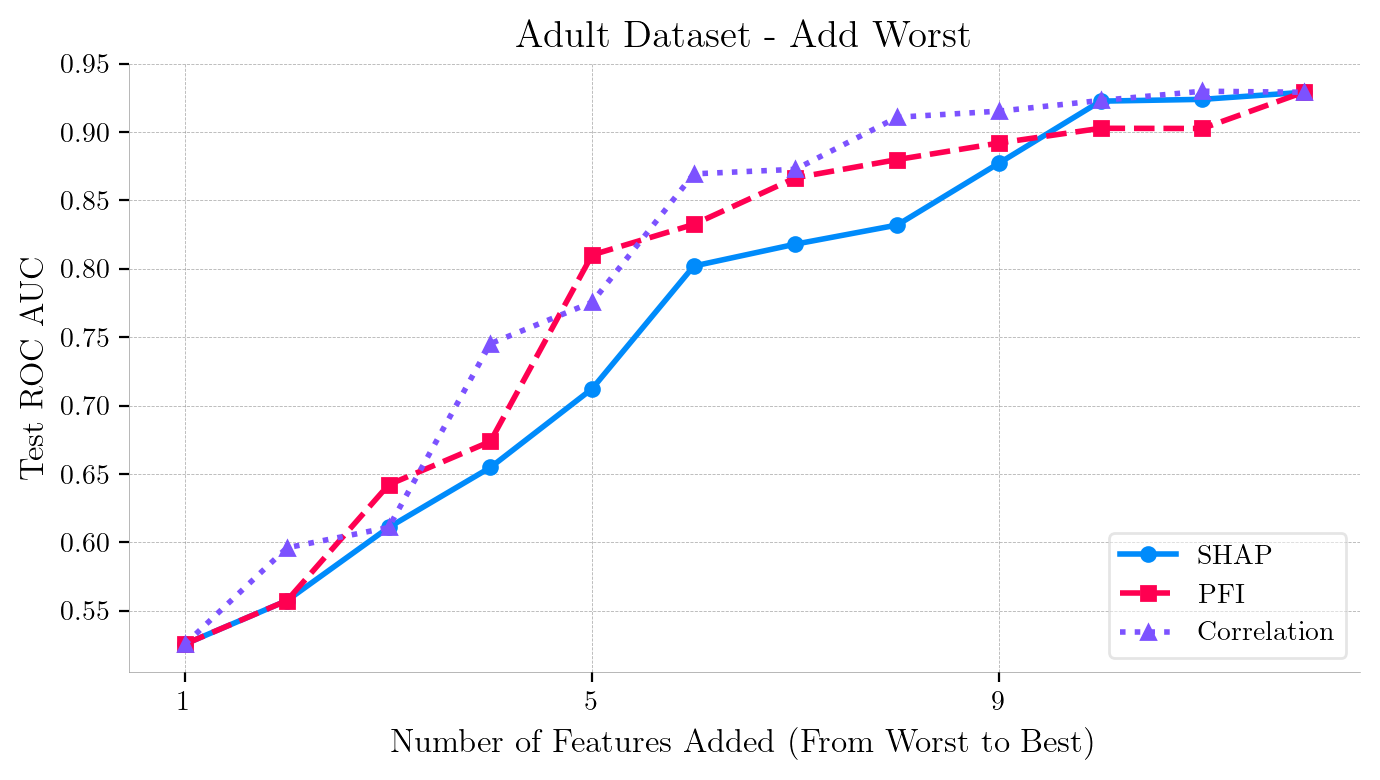

Done.


In [ ]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score

# ==========================================
# 1. LOAD & PREPROCESS DATA
# ==========================================
print("Loading and preprocessing Adult dataset...")

X, y = shap.datasets.adult()
X = pd.DataFrame(X, columns=X.columns)
feature_names = X.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale numeric features only (safe for XGBoost but keeps consistency)
numeric_cols = X.select_dtypes(include=[np.number]).columns

scaler = StandardScaler()
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])

# ==========================================
# 2. TRAIN BASELINE MODEL
# ==========================================
print("Training baseline XGBoost model...")

baseline_model = xgb.XGBClassifier(
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

baseline_model.fit(X_train_scaled, y_train)

baseline_pred = baseline_model.predict_proba(X_test_scaled)[:, 1]
print(f"Baseline ROC AUC: {roc_auc_score(y_test, baseline_pred):.4f}")
print("=" * 70)

# ==========================================
# 3. FEATURE IMPORTANCE RANKINGS
# ==========================================
print("Calculating feature rankings...")

# --- SHAP (Hardcoded Ranking) ---
# We bypass the TreeExplainer calculation to use the pre-defined order
shap_ranking = [
    "Age",
    "Relationship",
    "Marital Status",
    "Capital Gain",
    "Education-Num",
    "Hours per week",
    "Occupation",
    "Sex",
    "Capital Loss",
    "Workclass",
    "Race",
    "Country"
]

# --- Permutation Feature Importance ---
pfi = permutation_importance(
    baseline_model,
    X_test_scaled,
    y_test,
    n_repeats=15,
    random_state=42,
    scoring="roc_auc",
    n_jobs=-1
)

pfi_ranking = [
    f for _, f in sorted(zip(pfi.importances_mean, feature_names), reverse=True)
]

# --- Pearson Correlation (numeric features only) ---
train_corr = X_train_scaled[numeric_cols].copy()
train_corr["target"] = y_train

corr_values = (
    train_corr.corr()["target"]
    .abs()
    .drop("target")
    .sort_values(ascending=False)
)

# Append non-numeric features at the end (no correlation defined)
corr_ranking = corr_values.index.tolist() + [
    f for f in feature_names if f not in corr_values.index
]

rankings = {
    "SHAP": shap_ranking,
    "PFI": pfi_ranking,
    "Correlation": corr_ranking
}

# ==========================================
# 4. FEATURE ADDITION TRAJECTORY
# ==========================================
def get_trajectory_data(ranking, mode, X_tr, y_tr, X_te, y_te):
    """
    Single source of truth for feature addition experiments.
    """
    results = []

    if mode == "add_best":
        ordered = ranking
    elif mode == "add_worst":
        ordered = ranking[::-1]
    else:
        raise ValueError("Unsupported mode")

    for k in range(1, len(ordered) + 1):
        selected = ordered[:k]
        added_feature = ordered[k - 1]

        clf = xgb.XGBClassifier(
            eval_metric="logloss",
            use_label_encoder=False,
            random_state=42,
            n_jobs=-1
        )

        clf.fit(X_tr[selected], y_tr)
        preds = clf.predict_proba(X_te[selected])[:, 1]
        score = roc_auc_score(y_te, preds)

        results.append({
            "Step": k,
            "Feature_Added": added_feature,
            "ROC_AUC": score
        })

    return pd.DataFrame(results)

def trajectory_to_xy(df):
    return df["Step"].values, df["ROC_AUC"].values

# ==========================================
# 5. PRINT TABLES
# ==========================================
print("\nGenerating Iterative Feature Selection Scores...\n")

scenarios = ["add_best", "add_worst"]

for mode in scenarios:
    print("#" * 80)
    print(f"SCENARIO: {mode.upper().replace('_', ' ')}")
    print("#" * 80)

    for method, ranking in rankings.items():
        print(f"\n--- Method: {method} ---")
        df = get_trajectory_data(
            ranking, mode,
            X_train_scaled, y_train,
            X_test_scaled, y_test
        )
        print(df.to_string(index=False))
        print("-" * 60)

print("Tables generated.")
print("=" * 80)

# ==========================================
# 6. PLOTTING (USES SAME DATA)
# ==========================================
colors = {"SHAP": "#008BFB", "PFI": "#FF0051", "Correlation": "#7C52FF"}
markers = {"SHAP": "o", "PFI": "s", "Correlation": "^"}
styles = {"SHAP": "-", "PFI": "--", "Correlation": ":"}

plot_scenarios = [
    ("add_best", "Number of Features Added (from Best to Worst)"),
    ("add_worst", "Number of Features Added (from Worst to Best)")
]

print("Generating plots...")

for mode, xlabel in plot_scenarios:
    plt.figure(figsize=(7, 4))

    for method, ranking in rankings.items():
        df = get_trajectory_data(
            ranking, mode,
            X_train_scaled, y_train,
            X_test_scaled, y_test
        )
        xs, ys = trajectory_to_xy(df)

        plt.plot(
            xs, ys,
            label=method,
            color=colors[method],
            marker=markers[method],
            linestyle=styles[method],
            linewidth=2,
            markersize=5
        )
        
#             # ===== Annotate Max ROC AUC per method =====
#     legend_box = dict(boxstyle="round,pad=0.3", fc="white", ec="0.8", alpha=0.9)

#     x_offsets = {
#     "SHAP": 0.6,
#     "PFI": 0.0,
#     "Correlation": +0.4
# }

#     y_offsets = {
#         "SHAP": -0.06,
#         "PFI": -0.09,
#         "Correlation": +0.05
#     }
    
#     for method, ranking in rankings.items():
#         df = get_trajectory_data(
#             ranking, mode,
#             X_train_scaled, y_train,
#             X_test_scaled, y_test
#         )

#         xs = df["Step"].values
#         ys = df["ROC_AUC"].values

#         max_idx = np.argmax(ys)

#         plt.annotate(
#             f"Max {method}: {ys[max_idx]:.4f}",
#             xy=(xs[max_idx], ys[max_idx]),
#             xytext=(
#                 xs[max_idx] + x_offsets[method],
#                 ys[max_idx] + y_offsets[method]
#             ),
#             ha="center",
#             arrowprops=dict(
#                 facecolor=colors[method],
#                 edgecolor="white", 
#                 shrink=0.05
#             ),
#             bbox=legend_box
#         )

    plt.grid(True, linestyle="--", alpha=0.6)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel("Test ROC AUC", fontsize=12)
    plt.title(f"Adult Dataset - {mode.replace('_', ' ').title()}", fontsize=14)
    plt.xticks(range(1, len(feature_names) + 1, 4))
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

print("Done.")


In [ ]:
rankings

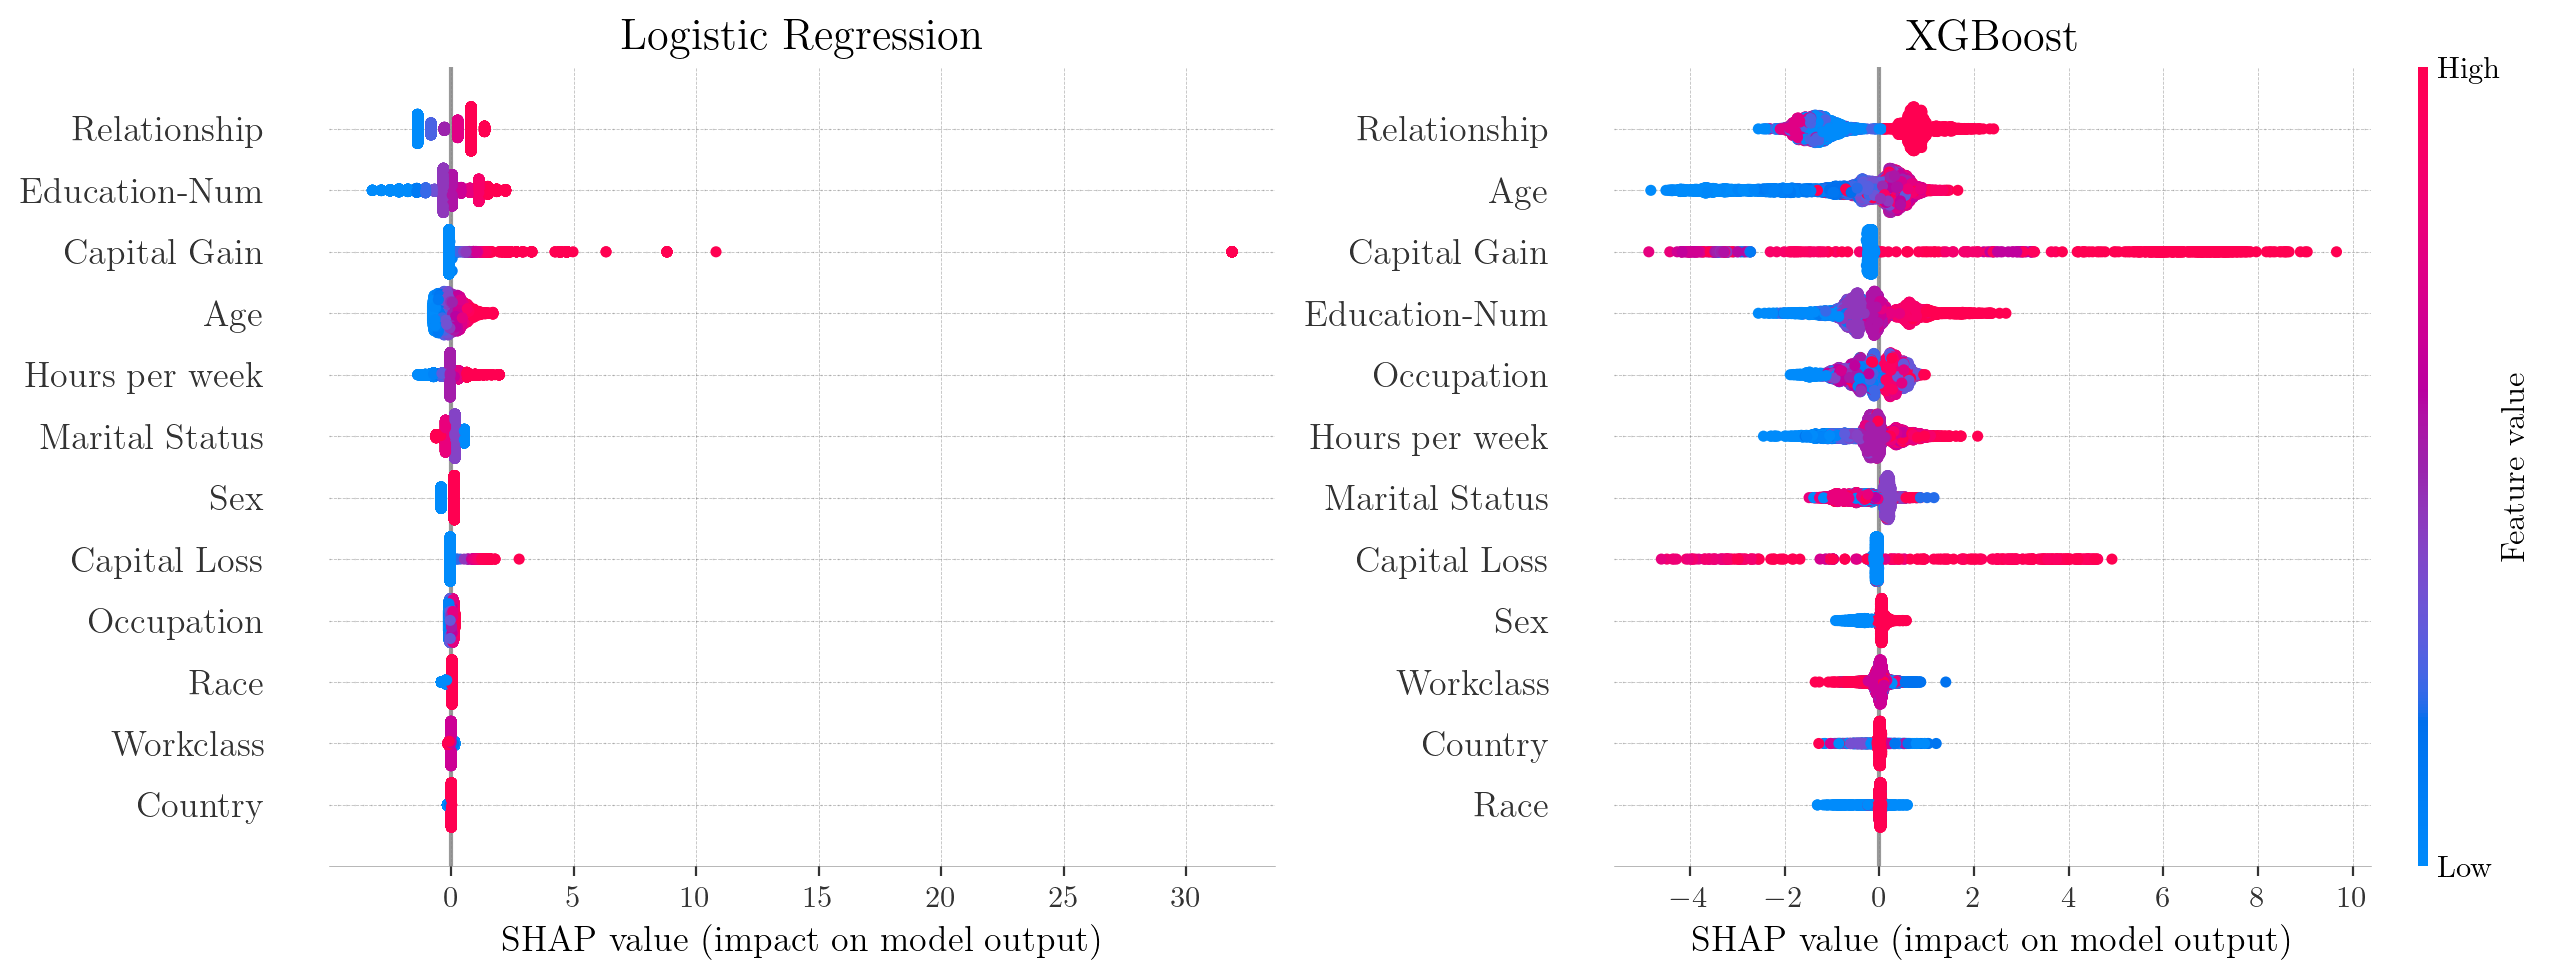


XGBoost Feature Importance (GAIN):
           feature       gain
0     Relationship  78.005264
1     Capital Gain  23.749170
2    Education-Num  14.763656
3     Capital Loss   9.314817
4       Occupation   4.434528
5   Marital Status   4.333042
6              Age   4.066617
7              Sex   3.815056
8   Hours per week   3.701942
9        Workclass   3.174754
10            Race   2.374681
11         Country   1.972880

XGBoost Feature Importance (COVER):
           feature        cover
0     Capital Loss  1029.949585
1     Capital Gain   955.891174
2   Marital Status   637.992493
3          Country   608.252502
4   Hours per week   452.010101
5             Race   439.712952
6     Relationship   426.895599
7       Occupation   381.830597
8              Age   324.394806
9        Workclass   304.564575
10   Education-Num   301.817871
11             Sex   211.409576

XGBoost Feature Importance (WEIGHT):
           feature  weight
0              Age   686.0
1   Hours per week   464.0
2 

In [10]:
import shap
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# 1. Load Data
X, y = shap.datasets.adult()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Train Logistic Regression
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

model_lr = LogisticRegression(max_iter=1000)
model_lr.fit(X_train_scaled, y_train)

# Use fewer samples for background to speed up plotting
background = shap.maskers.Independent(X_train_scaled, max_samples=100)
explainer_lr = shap.LinearExplainer(model_lr, background)
shap_values_lr = explainer_lr(X_test_scaled)

# 3. Train XGBoost
model_xgb = xgb.XGBClassifier(
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)
model_xgb.fit(X_train, y_train)

explainer_xgb = shap.TreeExplainer(model_xgb)
shap_values_xgb = explainer_xgb(X_test)

# 4. Plot Side-by-Side
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))

# Plot 1: Logistic Regression
plt.sca(axes[0]) 
plt.title("Logistic Regression", fontsize=16)
shap.summary_plot(shap_values_lr, X_test_scaled, show=False, plot_size=None, color_bar=False)

# Plot 2: XGBoost
plt.sca(axes[1])
plt.title("XGBoost", fontsize=16)
shap.summary_plot(shap_values_xgb, X_test, show=False, plot_size=None, color_bar=True)

plt.tight_layout()
plt.show()


# 5. Print XGBoost Feature Importance Metrics
booster = model_xgb.get_booster()

importance_types = ["gain", "cover", "weight"]

for imp_type in importance_types:
    print(f"\nXGBoost Feature Importance ({imp_type.upper()}):")
    
    scores = booster.get_score(importance_type=imp_type)
    
    # Convert to DataFrame
    df_importance = (
        pd.DataFrame(scores.items(), columns=["feature", imp_type])
        .sort_values(by=imp_type, ascending=False)
        .reset_index(drop=True)
    )
    
    print(df_importance)


In [1]:
# 1. Prepare Data (Adult Census Income Dataset)
# shap.datasets.adult() returns numerical features (integers for categories)
X, y = shap.datasets.adult() 

# Convert boolean labels to integers (0 or 1)
y = y.astype(int)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data (Important for Logistic Regression convergence)
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X.columns)

# 1. Extract Rankings
# PFI: Sort by 'PFI (mean F1 drop)' descending
pfi_ranking = df_importance.sort_values('PFI (mean F1 drop)', ascending=False)['Feature'].tolist()

# SHAP: Sort by 'SHAP (mean |val|)' descending
shap_ranking = df_importance.sort_values('SHAP (mean |val|)', ascending=False)['Feature'].tolist()

# --- NEW: Correlation Ranking ---
# Calculate absolute correlation between features and target (using training data)
# We temporarily combine X_train and y_train to easily calculate correlations
corr_df = X_train.copy()
corr_df['target'] = y_train
corr_ranking = corr_df.corr()['target'].abs().sort_values(ascending=False).drop('target').index.tolist()

# 2. Define Evaluation Function (Same as before)
def evaluate_feature_ranking(ranking, X_train, y_train, X_test, y_test, name):
    scores = []
    num_features = []
    
    print(f"Evaluating {name} ranking...")
    
    for k in range(1, len(ranking) + 1):
        top_k_features = ranking[:k]
        
        X_tr_sub = X_train[top_k_features]
        X_te_sub = X_test[top_k_features]
        
        lr_sub = LogisticRegression(max_iter=1000, random_state=42)
        lr_sub.fit(X_tr_sub, y_train)
        
        y_pred = lr_sub.predict(X_te_sub)
        score = f1_score(y_test, y_pred)
        
        scores.append(score)
        num_features.append(k)
        
    return num_features, scores

# 3. Run Evaluations
ns_shap, scores_shap = evaluate_feature_ranking(shap_ranking, X_train_scaled, y_train, X_test_scaled, y_test, "SHAP")
ns_pfi, scores_pfi = evaluate_feature_ranking(pfi_ranking, X_train_scaled, y_train, X_test_scaled, y_test, "PFI")
# --- NEW: Run Evaluation for Correlation ---
ns_corr, scores_corr = evaluate_feature_ranking(corr_ranking, X_train_scaled, y_train, X_test_scaled, y_test, "Correlation")


# 4. Plot Results
plt.figure(figsize=(7, 4))

shap_blue = "#008BFB"
shap_red = "#FF0051"
shap_purple = "#7C52FF"

# Plot SHAP Curve
plt.plot(ns_shap, scores_shap, marker='o', linestyle='-', color=shap_blue, label='SHAP Ranking', markersize=4)

# Plot PFI Curve
plt.plot(ns_pfi, scores_pfi, marker='s', linestyle='--', color=shap_red, label='PFI Ranking', markersize=4)

# --- NEW: Plot Correlation Curve ---
plt.plot(ns_corr, scores_corr, marker='^', linestyle='dotted', color=shap_purple, label='Correlation Ranking', markersize=4)


# Formatting
plt.xlabel('Number of Features (Added from Best to Worst)', fontsize=12)
plt.ylabel('Test Set F1 Score', fontsize=12)
#plt.xticks(range(0, 31, 2))
#plt.xticks(range(1, len(X.columns)+1, 2)) # Optional: Adjust ticks if crowded
plt.legend(loc='lower right', fontsize=12)
#plt.grid(True)

# Annotate Max F1 for each method
max_shap_idx = scores_shap.index(max(scores_shap))
max_pfi_idx = scores_pfi.index(max(scores_pfi))
max_corr_idx = scores_corr.index(max(scores_corr))

legend_box = dict(boxstyle="round,pad=0.3", fc="white", ec="0.8", alpha=0.9)

# SHAP Annotation
plt.annotate(
    f'Max SHAP: {scores_shap[max_shap_idx]:.4f}',
    xy=(ns_shap[max_shap_idx], scores_shap[max_shap_idx]),
    xytext=(ns_shap[max_shap_idx], scores_shap[max_shap_idx] - 0.05),
    ha='center',
    arrowprops=dict(facecolor=shap_blue, edgecolor='white', shrink=0.05),
    bbox=legend_box
)

# PFI Annotation
plt.annotate(
    f'Max PFI: {scores_pfi[max_pfi_idx]:.4f}',
    xy=(ns_pfi[max_pfi_idx], scores_pfi[max_pfi_idx]),
    xytext=(ns_pfi[max_pfi_idx], scores_pfi[max_pfi_idx] - 0.08),
    ha='center',
    arrowprops=dict(facecolor=shap_red, edgecolor="white", shrink=0.05),
    bbox=legend_box
)

# --- NEW: Correlation Annotation ---
plt.annotate(
    f'Max Corr: {scores_corr[max_corr_idx]:.4f}',
    xy=(ns_corr[max_corr_idx], scores_corr[max_corr_idx]),
    xytext=(ns_corr[max_corr_idx], scores_corr[max_corr_idx] + 0.04), # Moved up to avoid overlap
    ha='center',
    arrowprops=dict(facecolor=shap_purple, edgecolor='white', shrink=0.05),
    bbox=legend_box
)

plt.tight_layout()
plt.show()

print(f"Train shape: {X_train_scaled.shape}")
print(f"Test shape:  {X_test_scaled.shape}")
print("Adult dataset ready.")
# ----------------------------------------------------------------

NameError: name 'shap' is not defined

# XGBoost

Training XGBoost on Adult dataset...
Baseline F1 Score on Test Set: 0.7253
Computing SHAP values...
Computing PFI (scoring='f1')...


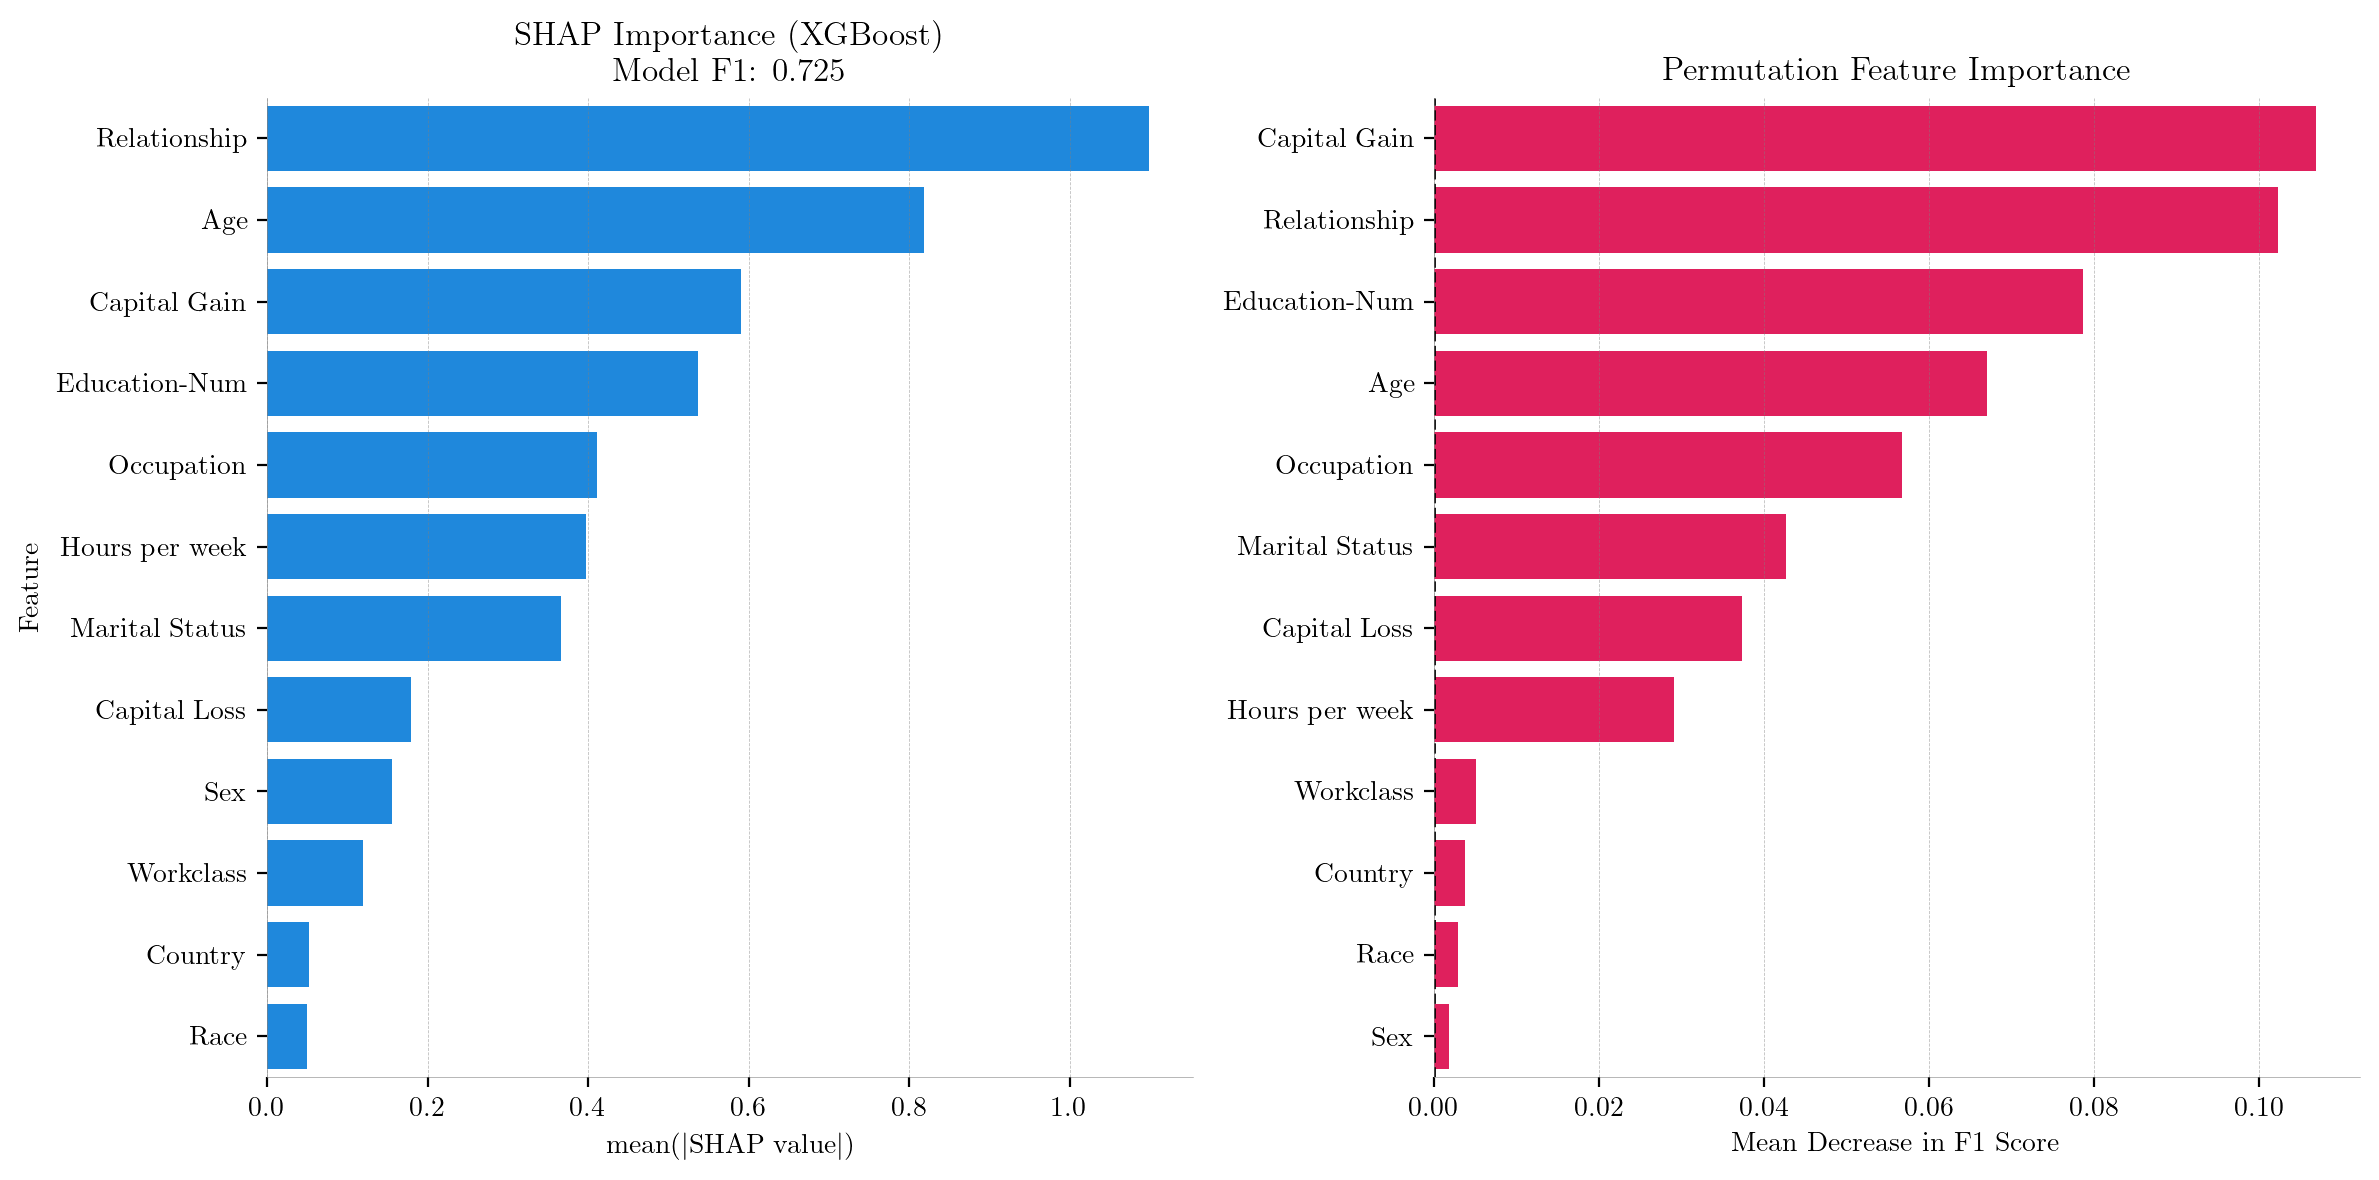

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import f1_score

# 1. Prepare Data
X, y = shap.datasets.adult()
y = y.astype(int) # Convert boolean to int

# Split data
# Note: XGBoost handles unscaled data well, so we skip StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 2. Train XGBoost
print("Training XGBoost on Adult dataset...")
xgb = XGBClassifier(
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train)

# --- Compute Baseline F1 Score ---
y_pred = xgb.predict(X_test)
baseline_f1 = f1_score(y_test, y_pred)
print(f"Baseline F1 Score on Test Set: {baseline_f1:.4f}")

# 3. Compute Feature Importance

# --- SHAP ---
print("Computing SHAP values...")
# TreeExplainer is the standard for XGBoost/RandomForest
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X_test)

# For binary XGBoost, shap_values is typically a single array (n_samples, n_features)
# representing log-odds changes. We take the mean absolute value.
shap_summary = np.abs(shap_values).mean(axis=0)

# --- Permutation Feature Importance (PFI) ---
print("Computing PFI (scoring='f1')...")
pfi = permutation_importance(
    xgb, 
    X_test, 
    y_test, 
    n_repeats=10, 
    random_state=42, 
    scoring='f1'
)
pfi_summary = pfi.importances_mean

# 4. Organize Data
df_importance = pd.DataFrame({
    'Feature': X.columns,
    'SHAP (mean |val|)': shap_summary,
    'PFI (mean F1 drop)': pfi_summary
})

# Sort by SHAP importance
df_shap_sorted = df_importance.sort_values('SHAP (mean |val|)', ascending=False)
df_pfi_sorted = df_importance.sort_values('PFI (mean F1 drop)', ascending=False)

# 5. Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

shap_blue = "#008BFB"
shap_red = "#FF0051"

# Plot 1: SHAP
sns.barplot(data=df_shap_sorted, x='SHAP (mean |val|)', y='Feature', ax=axes[0], color=shap_blue)
axes[0].set_xlabel('mean($|$SHAP value$|$)')
axes[0].set_title(f"SHAP Importance (XGBoost)\nModel F1: {baseline_f1:.3f}")

# Plot 2: PFI
sns.barplot(data=df_pfi_sorted, x='PFI (mean F1 drop)', y='Feature', ax=axes[1], color=shap_red)
axes[1].set_xlabel('Mean Decrease in F1 Score')
axes[1].set_ylabel('') 
axes[1].set_title("Permutation Feature Importance")

# Add a vertical line at 0 for PFI
axes[1].axvline(0, color='black', linewidth=1, linestyle='--')

plt.tight_layout()
plt.show()

In [ ]:
X["Country"].value_counts()

Country
39    29170
26      643
0       583
30      198
11      137
2       121
33      114
8       106
19      100
5        95
9        90
23       81
35       80
3        75
22       73
6        70
40       67
13       64
24       62
31       60
4        59
36       51
14       44
20       43
32       37
27       34
29       31
10       29
12       29
7        28
21       24
17       20
1        19
38       19
25       18
37       18
41       16
28       14
16       13
18       13
34       12
15        1
Name: count, dtype: int64

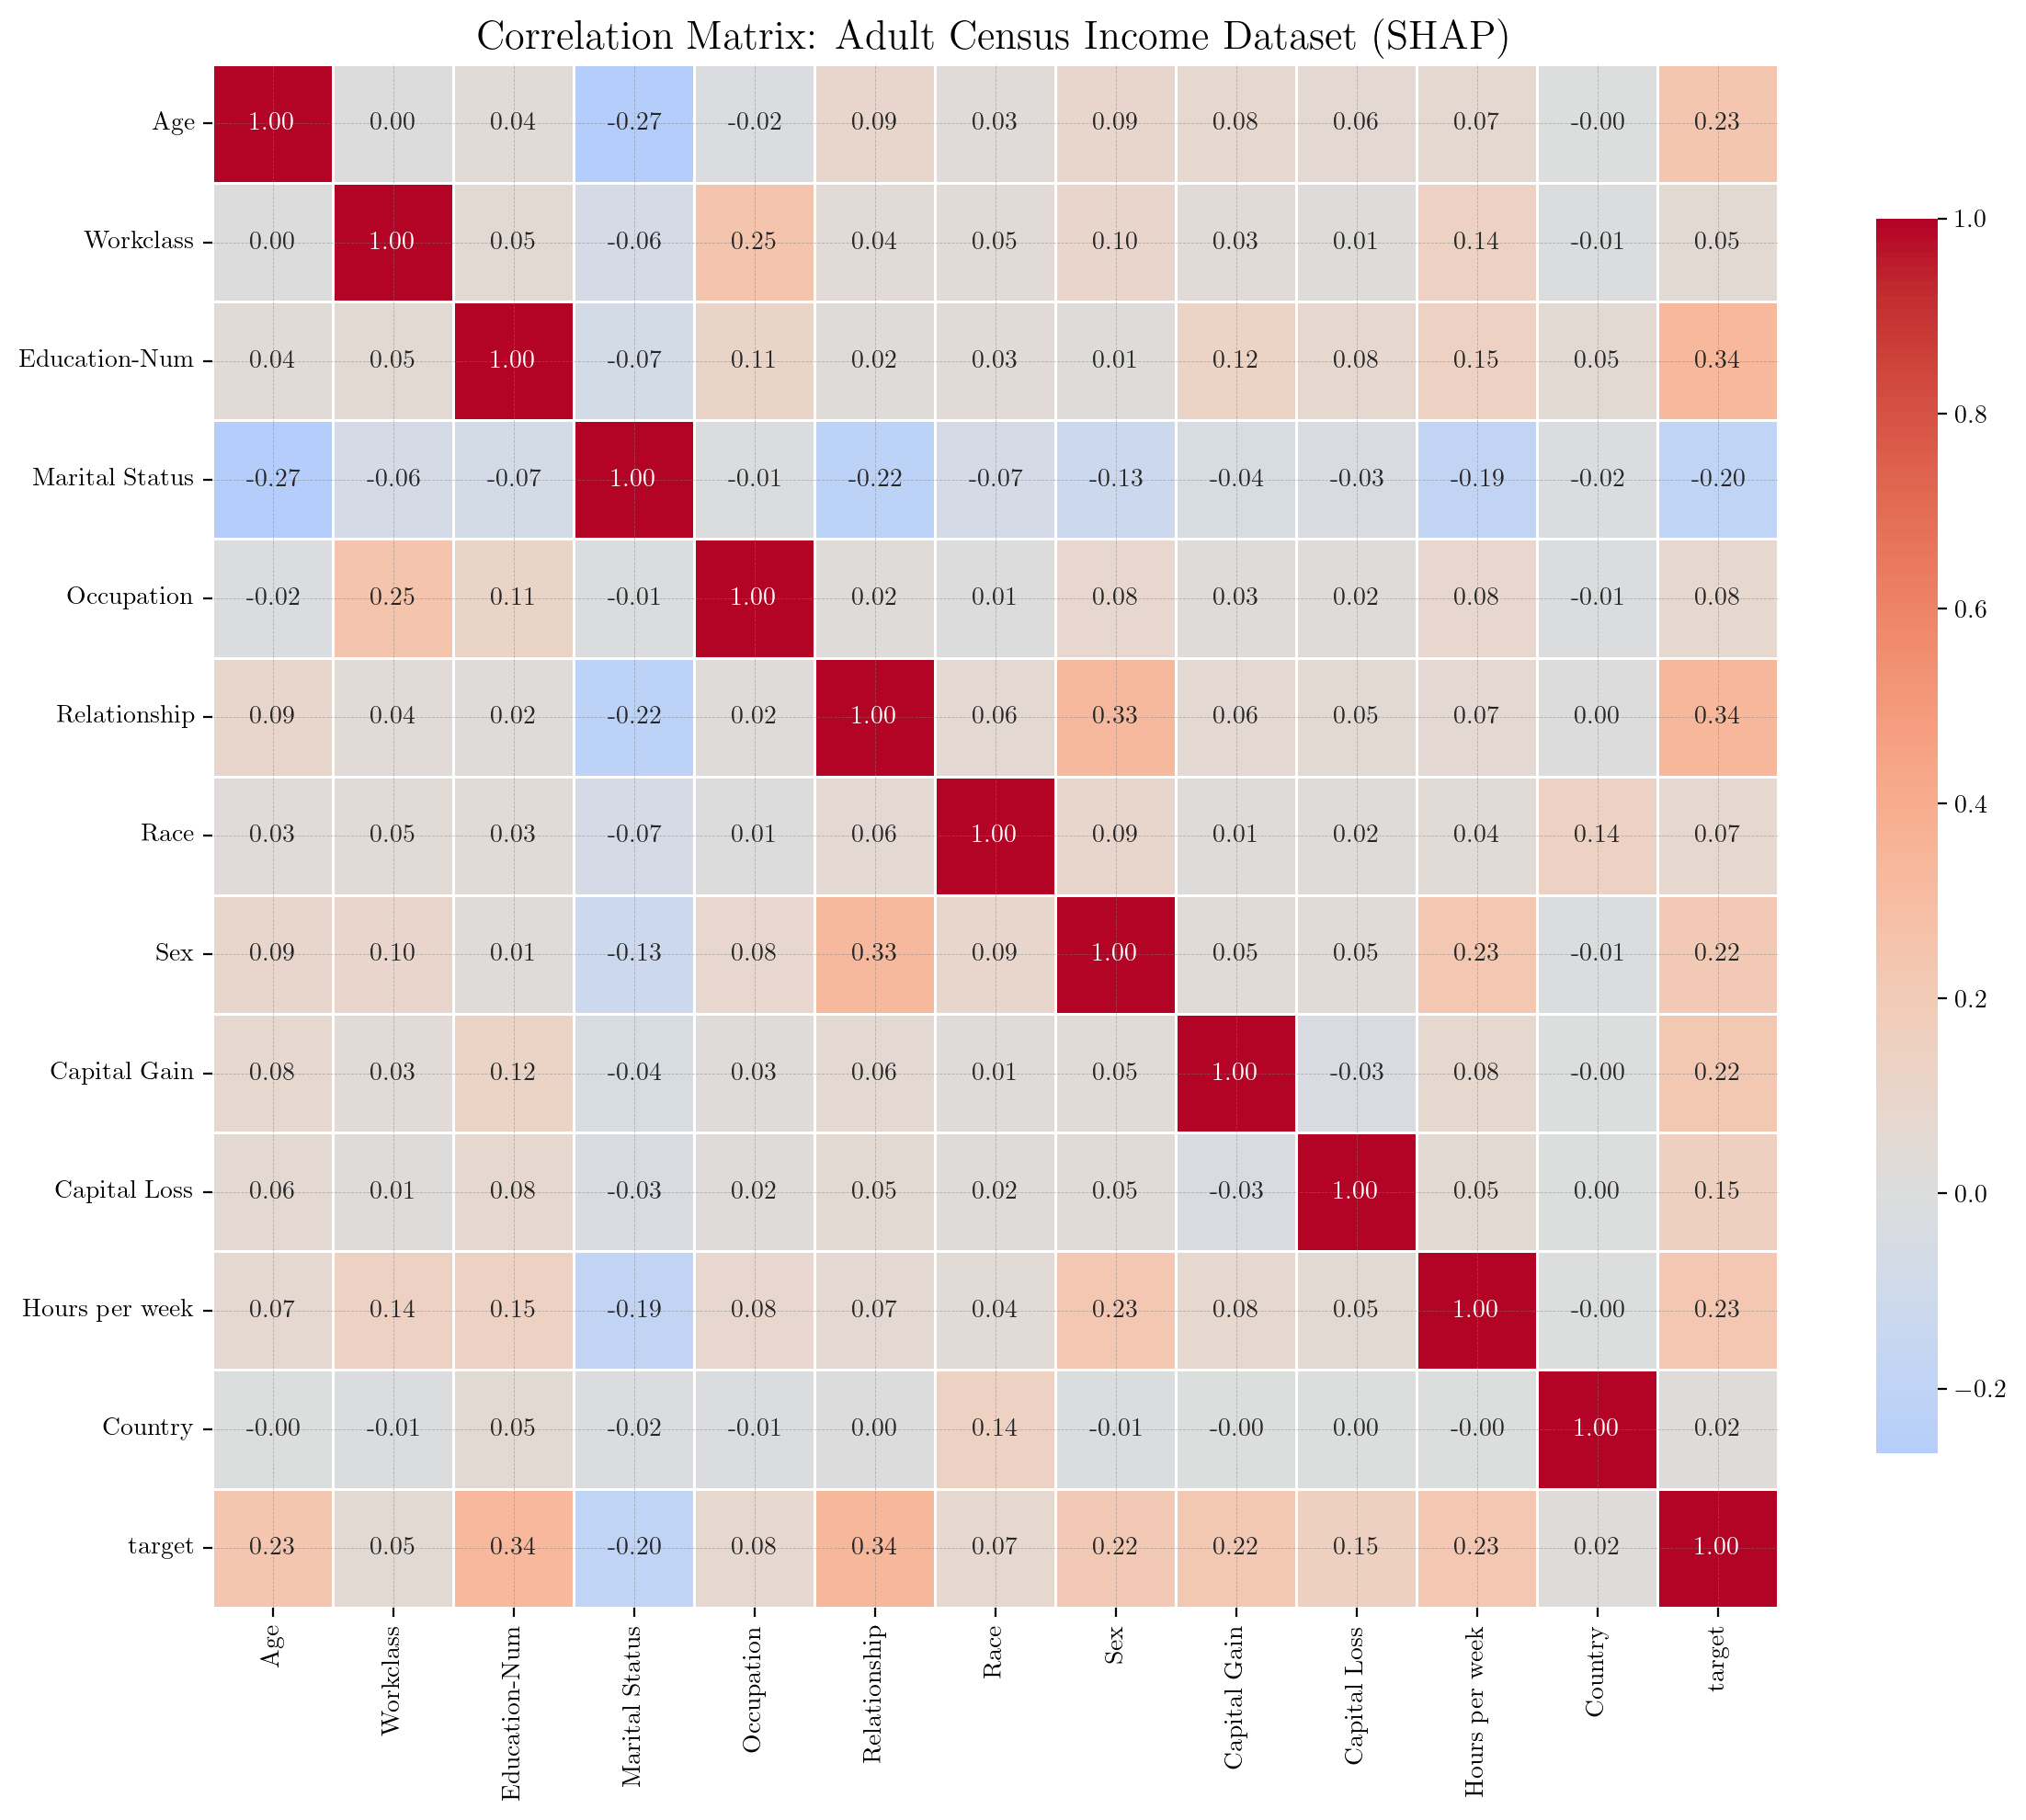

Sex
1    21790
0    10771
Name: count, dtype: int64


In [11]:
import shap
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Load the Adult dataset from SHAP
# X contains the features, y contains the target labels
X, y = shap.datasets.adult()

# 2. Prepare the DataFrame
df = X.copy()
df['target'] = y.astype(int)  # Ensure target is numeric for correlation

# 3. Compute the Correlation Matrix
corr_matrix = df.corr()

# 4. Plot the Correlation Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix, 
    annot=True,       # Show the correlation value
    fmt=".2f",        # Format to 2 decimal places
    cmap='coolwarm',  # Color map (Red=Positive, Blue=Negative)
    center=0,         # Center the colormap at 0
    linewidths=0.5,   # Space between cells
    cbar_kws={"shrink": 0.8}
)

plt.title('Correlation Matrix: Adult Census Income Dataset (SHAP)', fontsize=16)
plt.tight_layout()
plt.show()

print(df['Sex'].value_counts())

In [18]:
# Show correlation with target (feature name + value)
target_corr = corr_matrix["target"].sort_values(ascending=False)[1:]
print(target_corr.to_string())

Relationship      0.340323
Education-Num     0.335154
Age               0.234037
Hours per week    0.229689
Capital Gain      0.223329
Sex               0.215980
Capital Loss      0.150526
Occupation        0.075468
Race              0.071846
Workclass         0.051604
Country           0.015840
Marital Status   -0.199307


Encoding categorical features...
Computing NMI matrix...


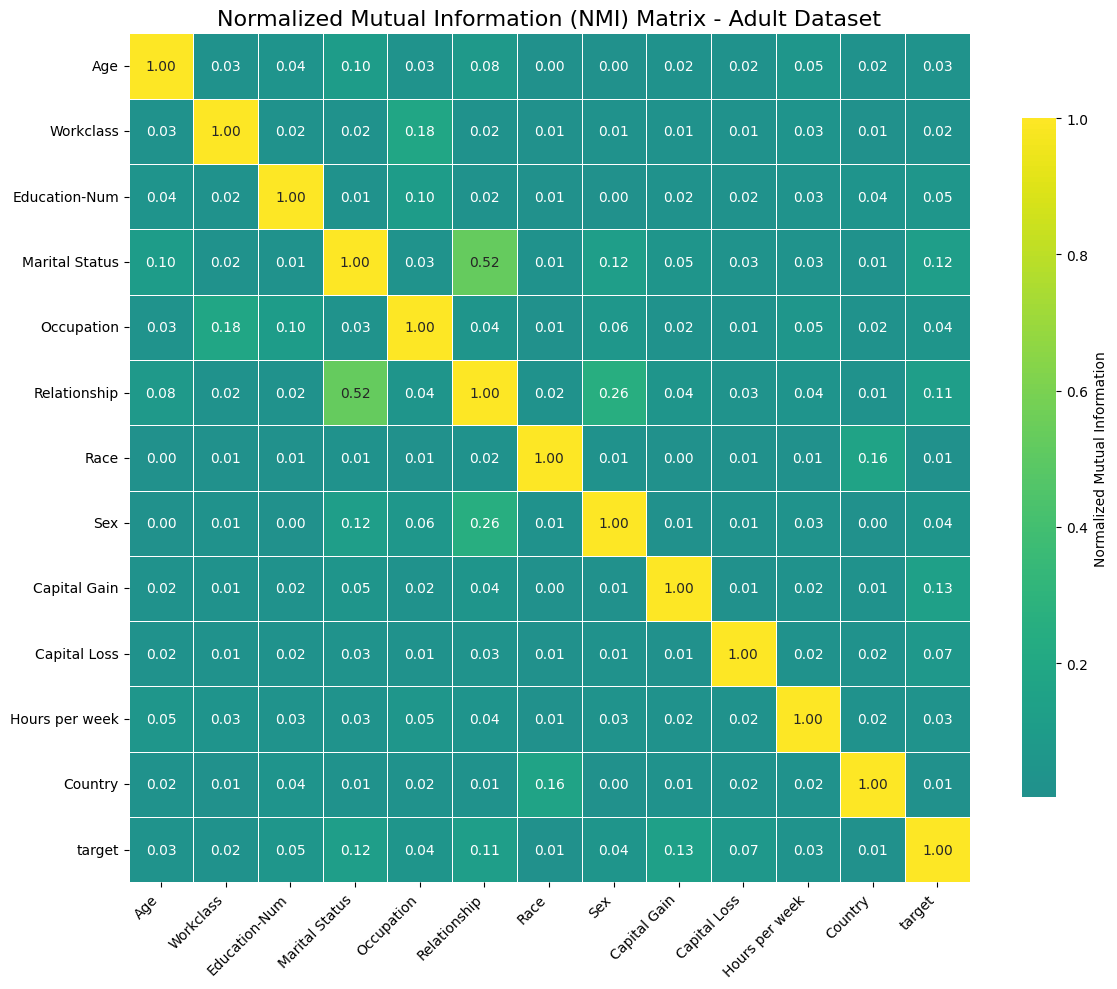

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy
from sklearn.preprocessing import LabelEncoder
import shap

# --- 1. Your Custom Metrics Functions (FIXED) ---
def freedman_diaconis_bins(x):
    # FIX: Force data to be numeric (float) to handle Booleans (True/False)
    x = np.asarray(x).astype(float)
    
    # Filter NaNs to prevent crashes
    x = x[~np.isnan(x)]
    if len(x) == 0: return 1
    
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    n = len(x)

    if iqr == 0: 
        return int(np.sqrt(n)) # fallback

    bin_width = 2 * iqr / (n ** (1 / 3))
    if bin_width == 0:
        return int(np.sqrt(n))
        
    bins = int(np.ceil((x.max() - x.min()) / bin_width))
    return max(2, bins)

def shannon_entropy(x, bins):
    x = x[~np.isnan(x)]
    hist, _ = np.histogram(x, bins=bins, density=False)
    prob = hist / hist.sum()
    prob = prob[prob > 0]
    return entropy(prob, base=2)

def mutual_information(x, y, bins_x, bins_y):
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask]
    y = y[mask]
    
    joint_hist, _, _ = np.histogram2d(x, y, bins=[bins_x, bins_y])
    joint_prob = joint_hist / joint_hist.sum()

    px = joint_prob.sum(axis=1)
    py = joint_prob.sum(axis=0)

    mi = 0.0
    for i in range(joint_prob.shape[0]):
        for j in range(joint_prob.shape[1]):
            if joint_prob[i, j] > 0:
                mi += joint_prob[i, j] * np.log2(
                    joint_prob[i, j] / (px[i] * py[j])
                )
    return mi

def normalized_mutual_information(x, y):
    # Ensure aligned data without NaNs and force to float
    mask = ~np.isnan(x) & ~np.isnan(y)
    x = x[mask].astype(float)
    y = y[mask].astype(float)

    bx = freedman_diaconis_bins(x)
    by = freedman_diaconis_bins(y)

    hx = shannon_entropy(x, bx)
    hy = shannon_entropy(y, by)
    mi = mutual_information(x, y, bx, by)

    if hx + hy == 0: return 0.0
    return 2 * mi / (hx + hy)

# --- 2. Load Data ---
X, y = shap.datasets.adult()
df = pd.DataFrame(X, columns=X.columns)
df['target'] = y

# --- 3. Preprocessing ---
print("Encoding categorical features...")
le = LabelEncoder()
for col in df.columns:
    # Check for object, category, OR bool types
    if df[col].dtype == 'object' or df[col].dtype.name == 'category' or df[col].dtype == 'bool':
        df[col] = le.fit_transform(df[col].astype(str))
    else:
        df[col] = df[col].fillna(df[col].mean())

# --- 4. Compute NMI Matrix ---
print("Computing NMI matrix...")
columns = df.columns
n_cols = len(columns)
nmi_matrix = pd.DataFrame(np.zeros((n_cols, n_cols)), index=columns, columns=columns)

# Loop over pairs (Upper Triangle Only for Speed)
for i in range(n_cols):
    for j in range(i, n_cols):
        col1 = columns[i]
        col2 = columns[j]
        
        # Compute NMI
        val = normalized_mutual_information(df[col1].values, df[col2].values)
        
        # Fill symmetric matrix
        nmi_matrix.loc[col1, col2] = val
        nmi_matrix.loc[col2, col1] = val

# --- 5. Plot Heatmap ---   
plt.figure(figsize=(12, 10))
sns.heatmap(
    nmi_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap='viridis', 
    center=0, 
    linewidths=0.5,
    cbar_kws={"shrink": .8, "label": "Normalized Mutual Information"}
)

plt.title('Normalized Mutual Information (NMI) Matrix - Adult Dataset', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Normalized Mutual Information with Target:
Capital Gain      0.127969
Marital Status    0.119031
Relationship      0.112082
Capital Loss      0.067021
Education-Num     0.050213
Sex               0.043421
Occupation        0.043087
Age               0.032427
Hours per week    0.028533
Workclass         0.017650
Race              0.010504
Country           0.009994
Name: target, dtype: float64


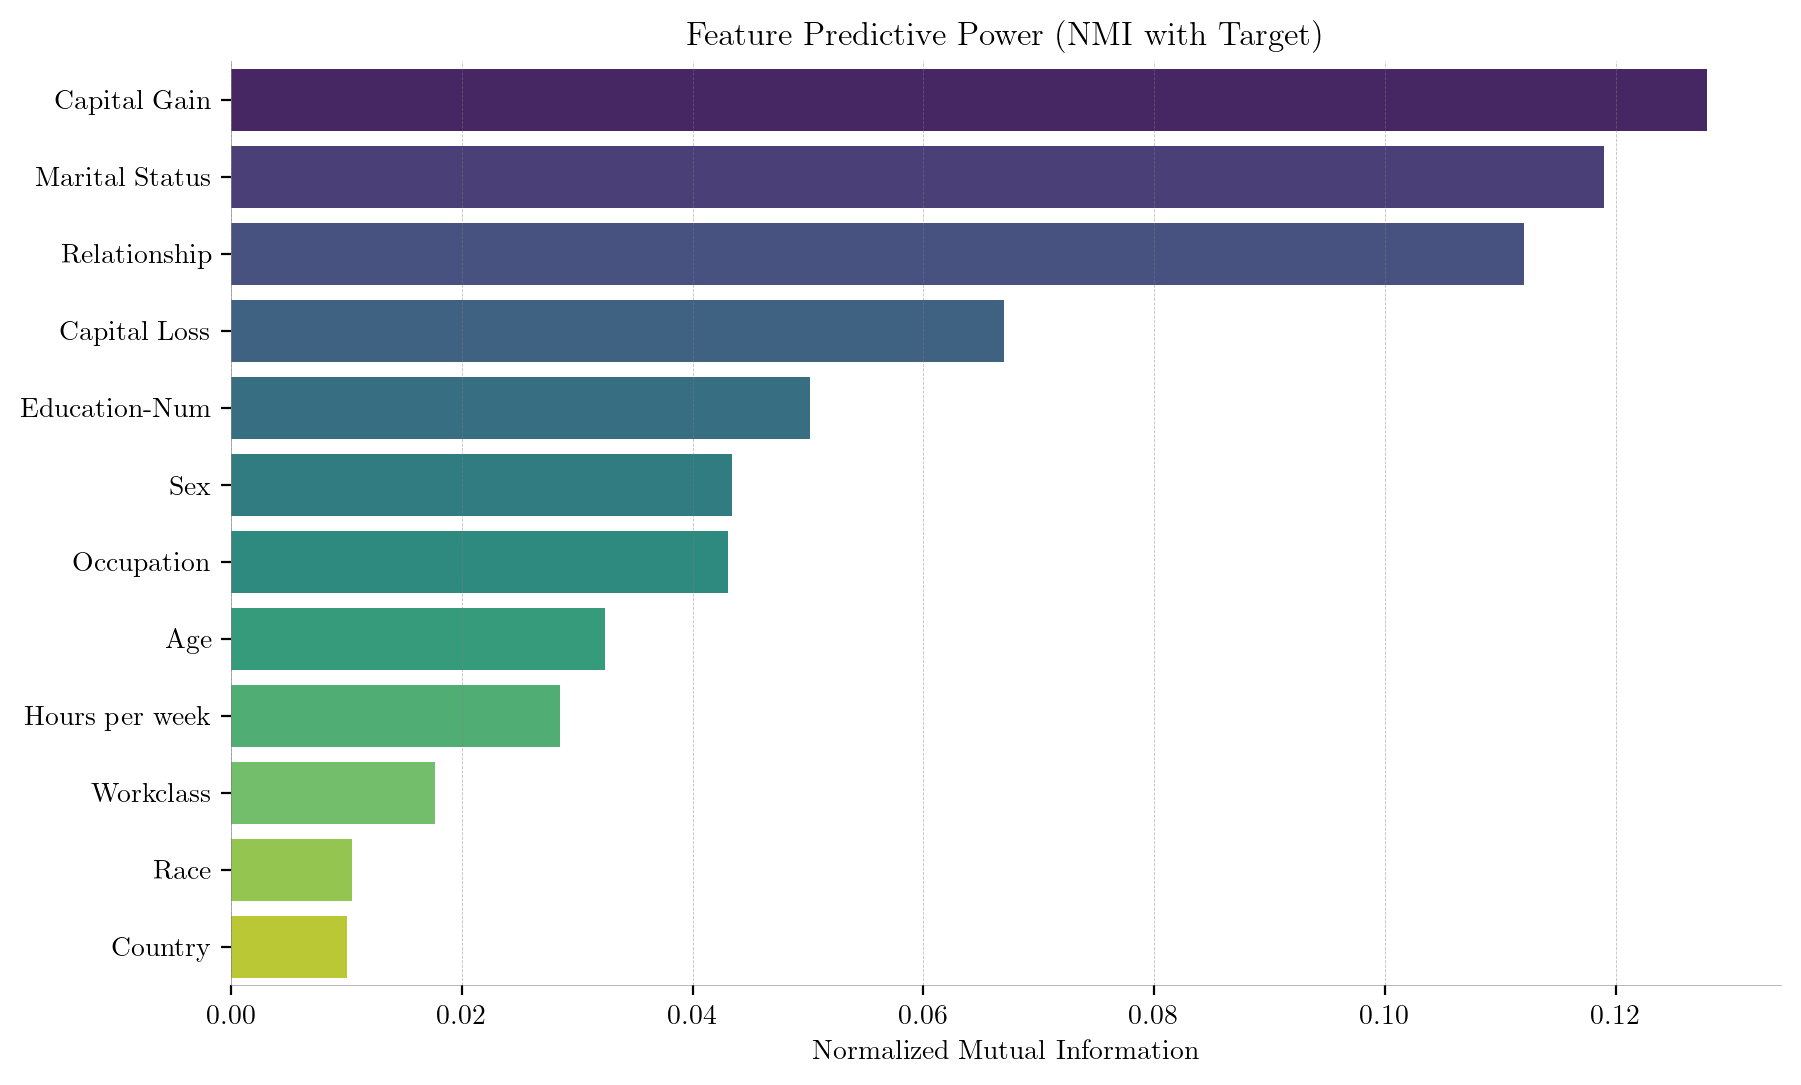

In [ ]:
# --- 6. Retrieve and Display Target NMI Series ---
# Extract the column corresponding to the target
target_nmi_series = nmi_matrix['target']

# Drop the 'target' vs 'target' row (which is always 1.0) to focus on features
target_nmi_series = target_nmi_series.drop('target')

# Sort in descending order to see the most predictive features first
target_nmi_series = target_nmi_series.sort_values(ascending=False)

print("Normalized Mutual Information with Target:")
print(target_nmi_series)

# Optional: Plot this specific series as a bar chart for clearer visualization
plt.figure(figsize=(10, 6))
sns.barplot(x=target_nmi_series.values, y=target_nmi_series.index, palette='viridis')
plt.title('Feature Predictive Power (NMI with Target)')
plt.ylabel('')
plt.xlabel('Normalized Mutual Information')
plt.show()